In [ ]:
import os
from pathlib import Path
os.chdir(Path.cwd().parent)
# print("cwd is now:", Path.cwd())

In [196]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter


def _logistic(x: np.ndarray) -> np.ndarray:
    x_clipped = np.clip(x, -500, 500)
    return 1.0 / (1.0 + np.exp(-x_clipped))


def plot_benchmark_forecast(
    benchmark_name: str,
    forecast_results: dict,
    df_cm: pd.DataFrame,
    df_db: pd.DataFrame,
    *,
    show_prediction_interval: bool = True,
    show_confidence_interval: bool = False,
    history_source_df: pd.DataFrame | None = None,
    title: str | None = None,
):
    """
    Plot historical and forecasted benchmark scores based on capability projections.

    Parameters
    - benchmark_name: exact name in df_db['benchmark_name'] and data_loader.scores_df['benchmark']
    - forecast_results: output dict from create_future_forecast(...) or create_post_cutoff_frontier_forecast(...)
        expected keys: 'forecast_df' with columns ['date','predicted_capability','ci_lower','ci_upper','pi_lower','pi_upper']
    - df_cm: model capabilities dataframe (e.g., df_cm1) with columns ['model','date','date_obj','estimated_capability']
    - df_db: benchmark params dataframe (e.g., df_db1) with columns ['benchmark_name','estimated_difficulty','estimated_slope']
    - history_source_df: optional raw scores dataframe to plot historical scores; if None tries to infer from earlier cells
    - show_prediction_interval/confidence_interval: overlay intervals from forecast_results if present
    - title: optional custom title
    """
    if forecast_results is None or len(forecast_results) == 0:
        raise ValueError("forecast_results is empty; run capability forecast first.")

    forecast_df = forecast_results.get("forecast_df")
    if forecast_df is None or forecast_df.empty:
        raise ValueError("forecast_results['forecast_df'] is missing or empty.")

    # Look up benchmark difficulty and slope
    bench_row = df_db.loc[df_db["benchmark_name"] == benchmark_name]
    if bench_row.empty:
        raise ValueError(f"Benchmark '{benchmark_name}' not found in df_db['benchmark_name'].")

    D_b = bench_row.iloc[0]["estimated_difficulty"]
    alpha_b = bench_row.iloc[0]["estimated_slope"]

    # Convert capability forecast to expected score via logistic(alpha_b * (C - D_b))
    C_hat = forecast_df["predicted_capability"].values
    score_forecast = _logistic(alpha_b * (C_hat - D_b))

    # Optional intervals propagated in capability space -> map endpoints through logistic
    ci_lower = forecast_df["ci_lower"].values if "ci_lower" in forecast_df.columns else None
    ci_upper = forecast_df["ci_upper"].values if "ci_upper" in forecast_df.columns else None
    pi_lower = forecast_df["pi_lower"].values if "pi_lower" in forecast_df.columns else None
    pi_upper = forecast_df["pi_upper"].values if "pi_upper" in forecast_df.columns else None

    score_ci_lower = _logistic(alpha_b * (ci_lower - D_b)) if ci_lower is not None and show_confidence_interval else None
    score_ci_upper = _logistic(alpha_b * (ci_upper - D_b)) if ci_upper is not None and show_confidence_interval else None
    score_pi_lower = _logistic(alpha_b * (pi_lower - D_b)) if pi_lower is not None and show_prediction_interval else None
    score_pi_upper = _logistic(alpha_b * (pi_upper - D_b)) if pi_upper is not None and show_prediction_interval else None

    # Historical points: take top/frontier capability per date, convert to score for this benchmark
    df_cap = df_cm.dropna(subset=["date_obj","estimated_capability"]).copy()
    df_cap.sort_values("date_obj", inplace=True)

    # Using all models per date: choose the max capability observed up to that date as proxy frontier
    df_cap["cum_max_capability"] = df_cap["estimated_capability"].cummax()
    hist_dates = df_cap["date_obj"].values
    hist_scores = _logistic(alpha_b * (df_cap["cum_max_capability"].values - D_b))

    # Raw benchmark history (optional): plot actual observed scores if provided
    hist_bench_dates = None
    hist_bench_scores = None
    if history_source_df is not None and "benchmark" in history_source_df.columns:
        df_hist = history_source_df[history_source_df["benchmark"] == benchmark_name].copy()
        if not df_hist.empty and "date" in df_hist.columns and "performance" in df_hist.columns:
            df_hist["date"] = pd.to_datetime(df_hist["date"], errors="coerce")
            df_hist = df_hist.dropna(subset=["date","performance"]).sort_values("date")
            hist_bench_dates = df_hist["date"].values
            hist_bench_scores = df_hist["performance"].values

    # Plot
    fig, ax = plt.subplots(figsize=(10, 5))

    # Historical implied scores from frontier capability
    ax.plot(hist_dates, hist_scores, color="#666", linewidth=1.5, label="Implied (frontier) score")

    # Actual observed historical scores if available
    if hist_bench_dates is not None:
        ax.scatter(hist_bench_dates, hist_bench_scores, s=16, alpha=0.7, color="#1f77b4", label="Observed scores")

    # Forecasted scores
    ax.plot(forecast_df["date"].values, score_forecast, color="red", linewidth=2.0, label="Forecast (score)")

    # Intervals
    if score_ci_lower is not None and score_ci_upper is not None:
        ax.fill_between(
            forecast_df["date"].values,
            score_ci_lower,
            score_ci_upper,
            color="red",
            alpha=0.25,
            label="95% CI (score)"
        )
    if score_pi_lower is not None and score_pi_upper is not None:
        ax.fill_between(
            forecast_df["date"].values,
            score_pi_lower,
            score_pi_upper,
            color="red",
            alpha=0.15,
            label="95% PI (score)"
        )

    ax.set_ylim(0, 1)
    ax.set_ylabel("Benchmark score (0–1)")
    ax.set_xlabel("Date")
    if title:
        ax.set_title(title)
    else:
        ax.set_title(f"Forecasted scores for '{benchmark_name}'")
    ax.legend(loc="lower right")
    ax.grid(True, linestyle=":", linewidth=0.7, alpha=0.6)

    ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
    fig.autofmt_xdate()
    plt.savefig(f"outputs/notebooks/benchmark_forecast_{benchmark_name.replace('/', '_').replace(' ', '_')}.pdf", dpi=300, bbox_inches='tight')
    plt.show()

    # Return a convenient DataFrame with the score forecast
    out = forecast_df.copy()
    out["forecasted_score"] = score_forecast
    if score_ci_lower is not None:
        out["score_ci_lower"] = score_ci_lower
        out["score_ci_upper"] = score_ci_upper
    if score_pi_lower is not None:
        out["score_pi_lower"] = score_pi_lower
        out["score_pi_upper"] = score_pi_upper
    return out


In [197]:

import seaborn as sns
sns.set()
sns.set_style("whitegrid")

# Custom color palette
custom_colors = [
    '#00A5A6',  # teal
    '#E03D90',  # pink
    '#FC6538',  # orange
    '#6A3ECB',  # purple
    '#0058DC',  # blue
    '#EA8D00',  # yellow
    '#B087F4',  # lightPurple
    '#279E27',  # green
    '#009AF1',  # lightBlue
    '#015D90',  # darkBlue
    '#EA4831',  # red
    '#E1C700',  # yellow2
    '#46FFFF',  # turquoise
    '#63F039',  # lightGreen
]

sns.set_palette(custom_colors)
colors = sns.color_palette()

# === Seaborn global settings ===
sns.set_theme(
    style="whitegrid",        # or "darkgrid", "ticks", "white"
    palette=custom_colors,    # your custom color palette
    context="notebook"        # scaling for labels/titles ("paper", "notebook", "talk", "poster")
)

# === Matplotlib global settings (rcParams) ===
plt.rcParams.update({
    # Figure
    "figure.figsize": (8, 5),
    "figure.dpi": 120,
    
    # Axes
    "axes.titley": 1.02,
    "axes.titlesize": 14,
    "axes.titlelocation": 'center',
    "axes.titlepad": 0,
    "axes.labelsize": 12,
    "axes.labelpad": 10,           # spacing between axis and label
    "axes.spines.top": False,
    "axes.spines.right": False,
    
    # Ticks
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    # tick marks size
    "xtick.major.size": 5,
    "ytick.major.size": 5,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    
    # tick visibility
    "xtick.top": False,
    "xtick.bottom": True,
    "ytick.left": True,
    "ytick.right": False,
    
    # Legend
    "legend.fontsize": 10,
    "legend.loc": "upper left",
    "legend.frameon": True,
    "legend.borderaxespad": 0,

    
    # Lines and markers
    "lines.linewidth": 2,
    "lines.markersize": 8,
    "lines.markeredgecolor": 'auto',   # white outline (stroke)
    "lines.markeredgewidth": 0.5,   
    # title alignment left
    

    
    
    # Error bars
    "errorbar.capsize": 3,
    
    # Font
    "font.family": "Arial",
    "font.sans-serif": ["DejaVu Sans"],
    
    # Grid
    "grid.alpha": 0.3,
    "grid.linestyle": "-",
    "grid.color": "lightgray",
})


In [198]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from sklearn.linear_model import LinearRegression


def _safe_logit(p: np.ndarray) -> np.ndarray:
    p = np.clip(p, 1e-6, 1 - 1e-6)
    return np.log(p / (1 - p))


def compare_benchmark_forecasts(
    benchmark_name: str,
    forecast_results: dict,
    df_cm: pd.DataFrame,
    df_db: pd.DataFrame,
    *,
    history_source_df: pd.DataFrame,
    min_points: int = 6,
    title: str | None = None,
):
    """
    Compare two forecast methods on a benchmark in one plot:
    1) Capability-based mapping using logistic(α(C-D)) from `forecast_results`
    2) Direct score extrapolation via logit-linear trend over time on historical scores

    Parameters
    - benchmark_name: name in history_source_df['benchmark'] and df_db['benchmark_name']
    - forecast_results: output from create_future_forecast(...)
    - df_cm: model capabilities dataframe used by capability forecast
    - df_db: benchmark params with columns ['benchmark_name','estimated_difficulty','estimated_slope']
    - history_source_df: raw scores with columns ['benchmark','date','performance'] (use data_loader.scores_df)
    - min_points: required number of historical points for direct extrapolation
    """
    if history_source_df is None:
        raise ValueError("history_source_df is required for direct extrapolation.")

    if forecast_results is None or len(forecast_results) == 0:
        raise ValueError("forecast_results is empty; run capability forecast first.")

    forecast_df = forecast_results.get("forecast_df")
    if forecast_df is None or forecast_df.empty:
        raise ValueError("forecast_results['forecast_df'] is missing or empty.")

    # 1) Capability-based forecast -> score
    bench_row = df_db.loc[df_db["benchmark_name"] == benchmark_name]
    if bench_row.empty:
        raise ValueError(f"Benchmark '{benchmark_name}' not found in df_db['benchmark_name'].")
    D_b = bench_row.iloc[0]["estimated_difficulty"]
    alpha_b = bench_row.iloc[0]["estimated_slope"]

    C_hat = forecast_df["predicted_capability"].values
    score_capability = 1.0 / (1.0 + np.exp(-(alpha_b * (C_hat - D_b))))

    # 2) Direct score extrapolation (logit-linear over time)
    df_hist = history_source_df[history_source_df["benchmark"] == benchmark_name].copy()
    if df_hist.empty:
        raise ValueError(f"No historical scores found for benchmark '{benchmark_name}'.")

    if "date" not in df_hist.columns or "performance" not in df_hist.columns:
        raise ValueError("history_source_df must include 'date' and 'performance' columns.")

    df_hist["date"] = pd.to_datetime(df_hist["date"], errors="coerce")
    df_hist = df_hist.dropna(subset=["date","performance"])  # remove NaN
    df_hist = df_hist.sort_values("date")

    # Aggregate to one point per date to avoid duplicates (take max or mean)
    daily = df_hist.groupby("date")["performance"].max().reset_index()

    if len(daily) < min_points:
        raise ValueError(f"Not enough points for direct extrapolation (have {len(daily)}, need >= {min_points}).")

    t0 = daily["date"].min()
    X_hist = (daily["date"] - t0).dt.days.values.reshape(-1, 1)
    y_hist = _safe_logit(daily["performance"].values)

    lr = LinearRegression()
    lr.fit(X_hist, y_hist)

    # Predict on the same forecast dates
    forecast_dates = pd.to_datetime(forecast_df["date"]).values
    X_fore = ((pd.to_datetime(forecast_df["date"]) - t0).dt.days.values).reshape(-1, 1)
    logit_pred = lr.predict(X_fore)
    score_direct = 1.0 / (1.0 + np.exp(-logit_pred))

    # Build plot
    fig, ax = plt.subplots(figsize=(10, 5))

    # Historical points (raw)
    ax.scatter(daily["date"].values, daily["performance"].values, s=18, alpha=0.75, color="#1f77b4", label="Observed scores")

    # Capability-implied forecast
    ax.plot(forecast_dates, score_capability, color="red", linewidth=2.0, label="Forecast via capabilities")

    # Direct extrapolation forecast
    ax.plot(forecast_dates, score_direct, color="#2ca02c", linewidth=2.0, linestyle="--", label="Forecast via direct scores")

    ax.set_ylim(0, 1)
    ax.set_ylabel("Benchmark score (0–1)")
    ax.set_xlabel("Date")
    if title:
        ax.set_title(title)
    else:
        ax.set_title(f"{benchmark_name}: Capability vs Direct Score Forecast")
    ax.legend(loc="lower right")
    ax.grid(True, linestyle=":", linewidth=0.7, alpha=0.6)

    ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
    fig.autofmt_xdate()
    plt.savefig(f"outputs/notebooks/compare_benchmark_forecasts_{benchmark_name.replace('/', '_').replace(' ', '_')}.pdf", dpi=300, bbox_inches='tight')
    plt.show()

    # Return both forecasts for downstream comparison
    out = pd.DataFrame({
        "date": pd.to_datetime(forecast_df["date"]).values,
        "score_capability": score_capability,
        "score_direct": score_direct,
    })
    return out


In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from data_loader import scores_df
from fit import fit_statistical_model
from sklearn.linear_model import LinearRegression

In [200]:
anchor_benchmark = "Winogrande"
anchor_difficulty = 0
anchor_slope = 1
df1, df_cm1, df_db1 = fit_statistical_model(scores_df, anchor_benchmark=anchor_benchmark, anchor_difficulty=anchor_difficulty, anchor_slope=anchor_slope)

# Convert date strings to datetime objects
df_cm1['date_obj'] = pd.to_datetime(df_cm1['date'])

`ftol` termination condition is satisfied.
Function evaluations 32, initial cost 4.5427e+01, final cost 3.4998e+00, first-order optimality 8.87e-04.


In [201]:
# keep only models released before cutoff
cutoff_date = "2024-07-01"
cutoff_date = pd.to_datetime(cutoff_date)
scores_df['date'] = pd.to_datetime(scores_df['date'], errors='coerce')
scores_df_cut = scores_df[scores_df['date'] < cutoff_date]
scores_df_cut = scores_df_cut[scores_df_cut['benchmark_release_date'] < cutoff_date]
dropped_models = set(scores_df['model']) - set(scores_df_cut['model'].unique())
print(f"Models dropped by date filter: {len(dropped_models)} →", dropped_models)
dropped_benchmarks = set(scores_df['benchmark']) - set(scores_df_cut['benchmark'].unique())
print(f"Benchmarks dropped by date filter: {len(dropped_benchmarks)} →", dropped_benchmarks)

anchor_benchmark = "Winogrande"
anchor_difficulty = 0
anchor_slope = 1
df2, df_cm2, df_db2 = fit_statistical_model(scores_df_cut, anchor_benchmark=anchor_benchmark, anchor_difficulty=anchor_difficulty, anchor_slope=anchor_slope)

Models dropped by date filter: 91 → {'DeepSeek-R1', 'claude-3-7-sonnet-20250219_16K', 'gemini-2.0-flash-001', 'gpt-4o-2024-08-06', 'mistral-medium-2505', 'o3-mini-2025-01-31_high', 'gemini-2.0-flash-exp', 'claude-sonnet-4-20250514_16K', 'gpt-4.5-preview-2025-02-27', 'gpt-5-nano-2025-08-07_high', 'claude-3-7-sonnet-20250219', 'gpt-4o-2024-11-20', 'claude-opus-4-20250514_16K', 'claude-3-5-sonnet-20241022', 'gpt-5-nano-2025-08-07_medium', 'o1-mini-2024-09-12_high', 'qwen3-235b-a22b', 'Llama-4-Scout-17B-16E-Instruct', 'DeepSeek-V3.1', 'Qwen2.5-Coder-32B', 'grok-3-beta', 'grok-3-mini-beta_high', 'Qwen2.5-VL-72B-Instruct', 'mistral-large-2407', 'grok-3-mini-beta_low', 'Llama-4-Maverick-17B-128E-Instruct-FP8', 'claude-sonnet-4-20250514', 'gpt-5-2025-08-07_medium', 'gemini-2.5-pro-preview-06-05', 'gpt-5-mini-2025-08-07_medium', 'claude-opus-4-1-20250805_16K', 'gemini-2.0-pro-exp-02-05', 'gemini-2.5-flash-preview-04-17', 'Llama-3.1-405B-Instruct', 'DeepSeek-V3', 'claude-3-5-haiku-20241022', 'o3

In [202]:
for i in [df1, df2, df_cm1, df_cm2, df_db1, df_db2]:
  print(len(i))

1306
533
170
79
39
18


# Forecasting Analysis

The following cells contain functions and analyses for forecasting frontier AI capabilities.


In [203]:
from pathlib import Path
from datetime import timedelta
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

# Define helper functions inline (to avoid import issues)
def prepare_model_data(df_capabilities: pd.DataFrame) -> pd.DataFrame:
    """Prepare model capabilities data with datetime conversion"""
    df = df_capabilities.copy()
    df['date_obj'] = pd.to_datetime(df['date'])
    return df.sort_values('date_obj')

def filter_by_date(df: pd.DataFrame, 
                  date_col: str, 
                  cutoff_date: str,
                  before: bool = True) -> pd.DataFrame:
    """Filter dataframe by date"""
    cutoff = pd.to_datetime(cutoff_date)
    if before:
        return df[df[date_col] <= cutoff].copy()
    else:
        return df[df[date_col] > cutoff].copy()

def bootstrap_slope_analysis(df: pd.DataFrame, 
                           x_col: str, 
                           y_col: str, 
                           n_bootstrap: int = 10000) -> dict:
    """Perform bootstrap analysis to estimate slope with confidence intervals"""
    # Convert dates to numeric if needed
    if df[x_col].dtype == 'datetime64[ns]':
        x_numeric = (df[x_col] - df[x_col].min()).dt.days
    else:
        x_numeric = df[x_col]
    
    # Bootstrap sampling
    slopes = []
    for _ in range(n_bootstrap):
        sample_idx = np.random.choice(len(df), size=len(df), replace=True)
        x_sample = x_numeric.iloc[sample_idx].values.reshape(-1, 1)
        y_sample = df[y_col].iloc[sample_idx].values
        
        model = LinearRegression()
        model.fit(x_sample, y_sample)
        
        # Convert slope to per-year if using days
        slope = model.coef_[0]
        if df[x_col].dtype == 'datetime64[ns]':
            slope *= 365.25  # Convert from per-day to per-year
            
        slopes.append(slope)
    
    slopes = np.array(slopes)
    
    return {
        'mean_slope': np.mean(slopes),
        'std_slope': np.std(slopes),
        'ci_2_5': np.percentile(slopes, 2.5),
        'ci_97_5': np.percentile(slopes, 97.5)
    }


## 1. Forecast Validation

This function validates forecast accuracy by comparing pre-cutoff predictions to post-cutoff reality.


In [204]:
def validate_forecast_accuracy(df_capabilities: pd.DataFrame, 
                             cutoff_date: str,
                             top_n_models: int,
                             label_frontier: bool = False):
    """Validate forecast accuracy by comparing pre-cutoff predictions to post-cutoff reality"""
    print(f"Validating forecast accuracy with cutoff date: {cutoff_date} using models that were top {top_n_models} at release")
    
    df = prepare_model_data(df_capabilities)
    cutoff_dt = pd.to_datetime(cutoff_date)
    
    # Get all data for context plots
    pre_cutoff_all = filter_by_date(df, 'date_obj', cutoff_date, before=True)
    post_cutoff_all = filter_by_date(df, 'date_obj', cutoff_date, before=False)
    
    # Identify frontier models using the same logic as create_future_forecast
    # But only use pre-cutoff data for training
    frontier_models_pre = []
    frontier_models_post = []
    
    for _, model in df.iterrows():
        model_release_date = model['date_obj']
        
        # Find all models that existed at or before this model's release date
        available_models = df[df['date_obj'] <= model_release_date]
        
        # Check if this model was among the top N at its release time
        top_models_at_release = available_models.nlargest(top_n_models, 'estimated_capability')
        
        if model['model'] in top_models_at_release['model'].values:
            if model_release_date <= cutoff_dt:
                frontier_models_pre.append(model)
            else:
                frontier_models_post.append(model)
    
    pre_cutoff = pd.DataFrame(frontier_models_pre)
    post_cutoff = pd.DataFrame(frontier_models_post)
    
    if len(pre_cutoff) == 0 or len(post_cutoff) == 0:
        print("Insufficient data for validation - skipping accuracy analysis")
        return {}
    
    # Fit model on pre-cutoff data
    X_pre = (pre_cutoff['date_obj'] - pre_cutoff['date_obj'].min()).dt.days.values.reshape(-1, 1)
    y_pre = pre_cutoff['estimated_capability'].values
    
    model = LinearRegression()
    model.fit(X_pre, y_pre)
    
    # Make predictions for post-cutoff dates
    X_post = (post_cutoff['date_obj'] - pre_cutoff['date_obj'].min()).dt.days.values.reshape(-1, 1)
    y_pred = model.predict(X_post)
    y_actual = post_cutoff['estimated_capability'].values
    
    # Calculate accuracy metrics
    mae = np.mean(np.abs(y_pred - y_actual))
    rmse = np.sqrt(np.mean((y_pred - y_actual)**2))
    r2 = 1 - np.sum((y_actual - y_pred)**2) / np.sum((y_actual - np.mean(y_actual))**2)
    
    # Create validation plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot all models (faded) for context
    ax.scatter(pre_cutoff_all['date_obj'], pre_cutoff_all['estimated_capability'], 
              alpha=0.2, s=64, label='All models (pre-cutoff)', color=colors[0])
    ax.scatter(post_cutoff_all['date_obj'], post_cutoff_all['estimated_capability'], 
              alpha=0.2, s=64, label='All models (post-cutoff)', color=colors[1])
    
    # Plot frontier models
    ax.scatter(pre_cutoff['date_obj'], pre_cutoff['estimated_capability'], 
              alpha=1, s=64, label=f'Frontier models (pre-cutoff)', color=colors[0])
    
    ax.scatter(post_cutoff['date_obj'], post_cutoff['estimated_capability'], 
              alpha=1, s=64, label=f'Frontier models (actual)', color=colors[1])

    # Optional labels for frontier models
    if label_frontier:
        for _, r in pre_cutoff.dropna(subset=['date_obj', 'estimated_capability']).iterrows():
            ax.annotate(
                r['model'],
                xy=(r['date_obj'], r['estimated_capability']),
                xytext=(4, 4),
                textcoords='offset points',
                fontsize=8,
                color=colors[0],
                alpha=0.9,
            )
        for _, r in post_cutoff.dropna(subset=['date_obj', 'estimated_capability']).iterrows():
            ax.annotate(
                r['model'],
                xy=(r['date_obj'], r['estimated_capability']),
                xytext=(4, 4),
                textcoords='offset points',
                fontsize=8,
                color=colors[1],
                alpha=0.9,
            )
    
    # Plot predictions
    # ax.scatter(post_cutoff['date_obj'], y_pred, 
    #           alpha=0.7, s=50, marker='x', label='Predicted', color='red')
    
    # Plot trend line
    all_dates = pd.concat([pre_cutoff['date_obj'], post_cutoff['date_obj']])
    X_all = (all_dates - pre_cutoff['date_obj'].min()).dt.days.values.reshape(-1, 1)
    y_trend = model.predict(X_all)
    ax.plot(all_dates, y_trend, 'r--', alpha=0.7, label='Trend line')
    
    # Add cutoff line
    ax.axvline(x=cutoff_dt, color='black', linestyle=':', alpha=0.7, label='Cutoff date')
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Estimated Capability')
    ax.set_title(f'Frontier Forecast Validation (Models that were Top {top_n_models} at Release, Cutoff: {cutoff_date})')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Format dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    plt.xticks(rotation=0)
    
    plt.tight_layout()
    plt.savefig(f"outputs/notebooks/frontier_forecast_validation.pdf", dpi=300, bbox_inches='tight')
    
    return {
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'n_training': len(pre_cutoff),
        'n_validation': len(post_cutoff),
        'slope': model.coef_[0] * 365.25,  # Convert to per-year
        'intercept': model.intercept_
    }


## 2. Future Forecast

This function creates forecasts for future capabilities based on models that were frontier at release.


In [205]:
def create_future_forecast(df_capabilities: pd.DataFrame,
                         forecast_years: int = 3,
                         top_n_models: int = 1,
                         label_frontier: bool = False):
    """Create forecast for future capabilities based on models that were frontier at release"""
    print(f"Creating {forecast_years}-year capability forecast using models that were top {top_n_models} at release...")
    
    df = prepare_model_data(df_capabilities)
    
    # Identify frontier models: those that were among top N when they were released
    frontier_models = []
    
    for _, model in df.iterrows():
        model_release_date = model['date_obj']
        model_capability = model['estimated_capability']
        
        # Find all models that existed at or before this model's release date
        available_models = df[df['date_obj'] <= model_release_date]
        
        # Check if this model was among the top N at its release time
        top_models_at_release = available_models.nlargest(top_n_models, 'estimated_capability')
        
        if model['model'] in top_models_at_release['model'].values:
            frontier_models.append(model)
    
    # Convert to DataFrame
    df_frontier = pd.DataFrame(frontier_models)
    
    print(f"Using {len(df_frontier)} frontier model data points (from {len(df)} total)")
    print(f"Frontier models: {', '.join(df_frontier.nsmallest(10, 'date_obj')['model'].tolist())}")
    
    # Prepare data for modeling using only frontier models
    X = (df_frontier['date_obj'] - df_frontier['date_obj'].min()).dt.days.values.reshape(-1, 1)
    y = df_frontier['estimated_capability'].values
    
    # Fit linear model
    model = LinearRegression()
    model.fit(X, y)
    
    # Also fit with statsmodels for confidence intervals
    X_sm = sm.add_constant(X.flatten())
    model_sm = sm.OLS(y, X_sm).fit()
    
    # Create forecast dates
    last_date = df['date_obj'].max()
    forecast_end = last_date + timedelta(days=365.25 * forecast_years)
    forecast_dates = pd.date_range(start=last_date, end=forecast_end, freq='ME')
    
    # Convert forecast dates to numeric
    X_forecast = (forecast_dates - df['date_obj'].min()).days.values.reshape(-1, 1)
    X_forecast_sm = sm.add_constant(X_forecast.flatten())
    
    # Make predictions
    y_forecast = model.predict(X_forecast)
    
    # Get confidence and prediction intervals from statsmodels
    forecast_sm = model_sm.get_prediction(X_forecast_sm)
    ci_lower = forecast_sm.conf_int()[:, 0]
    ci_upper = forecast_sm.conf_int()[:, 1]
    
    # Get prediction intervals - handle different statsmodels versions
    try:
        pi_lower = forecast_sm.prediction_interval[:, 0]
        pi_upper = forecast_sm.prediction_interval[:, 1]
    except AttributeError:
        # Fallback for older statsmodels versions or manual calculation
        prediction_std_err = forecast_sm.se_mean
        t_val = stats.t.ppf(0.975, model_sm.df_resid)  # 95% prediction interval
        pi_lower = y_forecast - t_val * prediction_std_err
        pi_upper = y_forecast + t_val * prediction_std_err
    
    # Create comprehensive forecast plot
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Plot all historical data (faded)
    ax.scatter(df['date_obj'], df['estimated_capability'], 
              alpha=0.2, s=64, label='All models', color=colors[0])
    
    # Plot frontier models data (highlighted)
    ax.scatter(df_frontier['date_obj'], df_frontier['estimated_capability'], 
              alpha=1, s=64, label=f'Models that were top {top_n_models} at release', color=colors[0])

    # Optional labels for frontier models
    if label_frontier:
        for _, r in df_frontier.dropna(subset=['date_obj', 'estimated_capability']).iterrows():
            ax.annotate(
                r['model'],
                xy=(r['date_obj'], r['estimated_capability']),
                xytext=(4, 4),
                textcoords='offset points',
                fontsize=8,
                color=colors[0],
                alpha=0.9,
            )
    
    # Plot historical trend (based on frontier models)
    y_hist_trend = model.predict(X)
    ax.plot(df_frontier['date_obj'], y_hist_trend, '--', alpha=0.7, label='Frontier trend', color=colors[0])
    
    # Plot forecast
    ax.plot(forecast_dates, y_forecast, '-', linewidth=2, label='Forecast', color=colors[1])
    
    # Plot confidence intervals
    ax.fill_between(forecast_dates, ci_lower, ci_upper, 
                   alpha=0.3, color=colors[1], label='95% Confidence interval')
    
    # Plot prediction intervals
    ax.fill_between(forecast_dates, pi_lower, pi_upper, 
                   alpha=0.2, color=colors[1], label='95% Prediction interval')
    
    # Add vertical line for present
    ax.axvline(x=last_date, color='black', linestyle=':', alpha=0.7, label='Present')
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Estimated Capability')
    ax.set_title(f'{forecast_years}-Year AI Frontier Capability Forecast (Models that were Top {top_n_models} at Release)')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Format dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    # ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    plt.xticks(rotation=0)
    
    plt.tight_layout()
    
    # Create forecast table
    forecast_df = pd.DataFrame({
        'date': forecast_dates,
        'predicted_capability': y_forecast,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'pi_lower': pi_lower,
        'pi_upper': pi_upper
    })
    
    return {
        'model': model,
        'forecast_df': forecast_df,
        'slope_per_year': model.coef_[0] * 365.25,
        'r2': model.score(X, y),
        'model_summary': model_sm.summary()
    }


## 3. Post-Cutoff Frontier Forecast

This function creates a forecast using only post-cutoff frontier models.


In [206]:
def create_post_cutoff_frontier_forecast(
    df_capabilities: pd.DataFrame,
    cutoff_date: str,
    forecast_years: int = 3,
    top_n_models: int = 1,
    label_frontier: bool = False,
):
    """Create a post-cutoff forecast using only models that were frontier at release AFTER the cutoff."""
    print(
        f"Creating post-cutoff ({cutoff_date}) {forecast_years}-year forecast using models that were top {top_n_models} at release..."
    )

    df = prepare_model_data(df_capabilities)
    cutoff_dt = pd.to_datetime(cutoff_date)

    # Identify post-cutoff frontier models
    post_cutoff_frontier_models = []

    for _, model_row in df.iterrows():
        model_release_date = model_row['date_obj']
        if pd.isna(model_release_date) or pd.isna(model_row['estimated_capability']):
            continue

        if model_release_date <= cutoff_dt:
            continue

        available_models = df[df['date_obj'] <= model_release_date]
        top_models_at_release = available_models.nlargest(top_n_models, 'estimated_capability')

        if model_row['model'] in top_models_at_release['model'].values:
            post_cutoff_frontier_models.append(model_row)

    df_frontier_post = pd.DataFrame(post_cutoff_frontier_models)

    if len(df_frontier_post) < 2:
        print("Insufficient post-cutoff frontier data points to fit a trend. Skipping post-cutoff forecast plot.")
        return {}

    # Prepare numeric features from post-cutoff data only
    x0 = df_frontier_post['date_obj'].min()
    X = (df_frontier_post['date_obj'] - x0).dt.days.values.reshape(-1, 1)
    y = df_frontier_post['estimated_capability'].values

    # Fit models
    lr_model = LinearRegression()
    lr_model.fit(X, y)

    X_sm = sm.add_constant(X.flatten())
    ols_model = sm.OLS(y, X_sm).fit()

    # Forecast horizon based on latest available date in the full dataset
    last_date = df['date_obj'].max()
    forecast_end = last_date + timedelta(days=365.25 * forecast_years)
    forecast_dates = pd.date_range(start=last_date, end=forecast_end, freq='ME')

    # Use the same baseline (x0) for conversion to numeric
    X_forecast = (forecast_dates - x0).days.values.reshape(-1, 1)
    X_forecast_sm = sm.add_constant(X_forecast.flatten())

    # Predictions
    y_hist_trend = lr_model.predict(X)
    y_forecast = lr_model.predict(X_forecast)

    # Confidence and prediction intervals via statsmodels
    forecast_sm = ols_model.get_prediction(X_forecast_sm)
    ci_lower = forecast_sm.conf_int()[:, 0]
    ci_upper = forecast_sm.conf_int()[:, 1]

    try:
        pi_lower = forecast_sm.prediction_interval[:, 0]
        pi_upper = forecast_sm.prediction_interval[:, 1]
    except AttributeError:
        prediction_std_err = forecast_sm.se_mean
        t_val = stats.t.ppf(0.975, ols_model.df_resid)
        pi_lower = y_forecast - t_val * prediction_std_err
        pi_upper = y_forecast + t_val * prediction_std_err

    # Plot
    fig, ax = plt.subplots(figsize=(14, 8))

    # Context: all models
    ax.scatter(
        df['date_obj'],
        df['estimated_capability'],
        alpha=0.25,
        s=64,
        label='All models',
        color=colors[0],
    )

    # Highlight: post-cutoff frontier models used for fit
    ax.scatter(
        df_frontier_post['date_obj'],
        df_frontier_post['estimated_capability'],
        alpha=1,
        s=64,
        label=f'Post-cutoff models that were top {top_n_models} at release',
        color=colors[0],
    )

    # Optional labels for frontier models (post-cutoff)
    if label_frontier:
        for _, r in df_frontier_post.dropna(subset=['date_obj', 'estimated_capability']).iterrows():
            ax.annotate(
                r['model'],
                xy=(r['date_obj'], r['estimated_capability']),
                xytext=(4, 4),
                textcoords='offset points',
                fontsize=8,
                color=colors[0],
                alpha=1,
            )

    # Trend on the post-cutoff segment
    ax.plot(
        df_frontier_post['date_obj'], y_hist_trend, '--', alpha=0.8, label='Post-cutoff frontier trend', color=colors[0]
    )

    # Forecast and intervals
    ax.plot(forecast_dates, y_forecast, '-', linewidth=2, label='Post-cutoff forecast', color=colors[1])
    ax.fill_between(
        forecast_dates, ci_lower, ci_upper, alpha=0.3, label='95% Confidence interval', color=colors[1]
    )
    ax.fill_between(
        forecast_dates, pi_lower, pi_upper, alpha=0.2, label='95% Prediction interval', color=colors[1]
    )

    # Lines for cutoff and present
    ax.axvline(x=cutoff_dt, color='black', linestyle=':', alpha=0.7, label='Cutoff date')
    ax.axvline(x=last_date, color='gray', linestyle='--', alpha=0.7, label='Present')

    ax.set_xlabel('Date')
    ax.set_ylabel('Estimated Capability')
    ax.set_title(
        f'Post-cutoff Frontier Forecast (Top {top_n_models} at Release after {cutoff_date}, +{forecast_years}y)'
    )
    ax.grid(True, alpha=0.3)
    ax.legend()

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Save
    forecast_df = pd.DataFrame(
        {
            'date': forecast_dates,
            'predicted_capability': y_forecast,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper,
            'pi_lower': pi_lower,
            'pi_upper': pi_upper,
        }
    )

    return {
        'model': lr_model,
        'forecast_df': forecast_df,
        'slope_per_year': lr_model.coef_[0] * 365.25,
        'r2': lr_model.score(X, y),
        'model_summary': ols_model.summary(),
        'n_points': len(df_frontier_post),
    }


## 4. Benchmark Saturation Forecasts

This function forecasts when models will reach 50% performance on different benchmarks.


In [207]:
def analyze_benchmark_saturation_forecasts(df_capabilities: pd.DataFrame,
                                         df_benchmarks: pd.DataFrame):
    """Forecast when models will reach 50% performance on different benchmarks"""
    print("Analyzing benchmark saturation forecasts...")
    
    # Get capability growth rate
    df_cap = prepare_model_data(df_capabilities)
    # Remove rows with NaN values in date or estimated_capability
    df_cap_clean = df_cap.dropna(subset=['date_obj', 'estimated_capability'])
    growth_stats = bootstrap_slope_analysis(df_cap_clean, 'date_obj', 'estimated_capability')
    annual_growth = growth_stats['mean_slope']
    
    # Current maximum capability
    current_max_capability = df_cap_clean['estimated_capability'].max()
    current_date = df_cap_clean['date_obj'].max()
    
    # For each benchmark, estimate when 50% performance will be reached
    saturation_forecasts = []
    
    for _, benchmark in df_benchmarks.iterrows():
        difficulty = benchmark['estimated_difficulty']
        
        # When C_m - D_b = 0, sigmoid gives 50% performance
        capability_needed = difficulty
        
        if capability_needed > current_max_capability:
            # Calculate time needed
            capability_gap = capability_needed - current_max_capability
            years_needed = capability_gap / annual_growth
            saturation_date = current_date + timedelta(days=365.25 * years_needed)
        else:
            # Already achievable
            saturation_date = current_date
            years_needed = 0
        
        saturation_forecasts.append({
            'benchmark': benchmark['benchmark_name'],
            'difficulty': difficulty,
            'capability_needed': capability_needed,
            'years_to_saturation': years_needed,
            'predicted_saturation_date': saturation_date
        })
    
    # Convert to DataFrame and sort by years needed
    saturation_df = pd.DataFrame(saturation_forecasts)
    saturation_df = saturation_df.sort_values('years_to_saturation')
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Plot for benchmarks that will be saturated within 5 years
    near_term = saturation_df[saturation_df['years_to_saturation'] <= 5]
    
    if len(near_term) > 0:
        y_pos = np.arange(len(near_term))
        bars = ax.barh(y_pos, near_term['years_to_saturation'])
        
        ax.set_yticks(y_pos)
        ax.set_yticklabels(near_term['benchmark'])
        ax.set_xlabel('Years to 50% Saturation')
        ax.set_title('Predicted Benchmark Saturation Timeline (Next 5 Years)')
        ax.grid(True, alpha=0.3, axis='x')
        
        # Add current date reference
        ax.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Present')
        ax.legend()
    
    plt.tight_layout()
    
    return saturation_df


---
## Run Analysis

Now let's run all the forecasting analyses using the fitted model data from the earlier cells.


### Set Analysis Parameters


In [208]:
# Analysis parameters
CUTOFF_DATE = '2024-09-01'  # Date for validation split
FORECAST_YEARS = 3  # Number of years to forecast ahead
TOP_N_MODELS = 1  # Number of top models at release to use for frontier (1 = pure frontier)
LABEL_FRONTIER = False  # Whether to annotate frontier model names on plots


### 1. Run Forecast Validation


Validating forecast accuracy with cutoff date: 2024-09-01 using models that were top 1 at release

Validation Results (cutoff: 2024-09-01):
  MAE: 4.284
  RMSE: 4.314
  R²: -518.450
  Annual growth rate: 2.340
  Training points: 2
  Validation points: 6


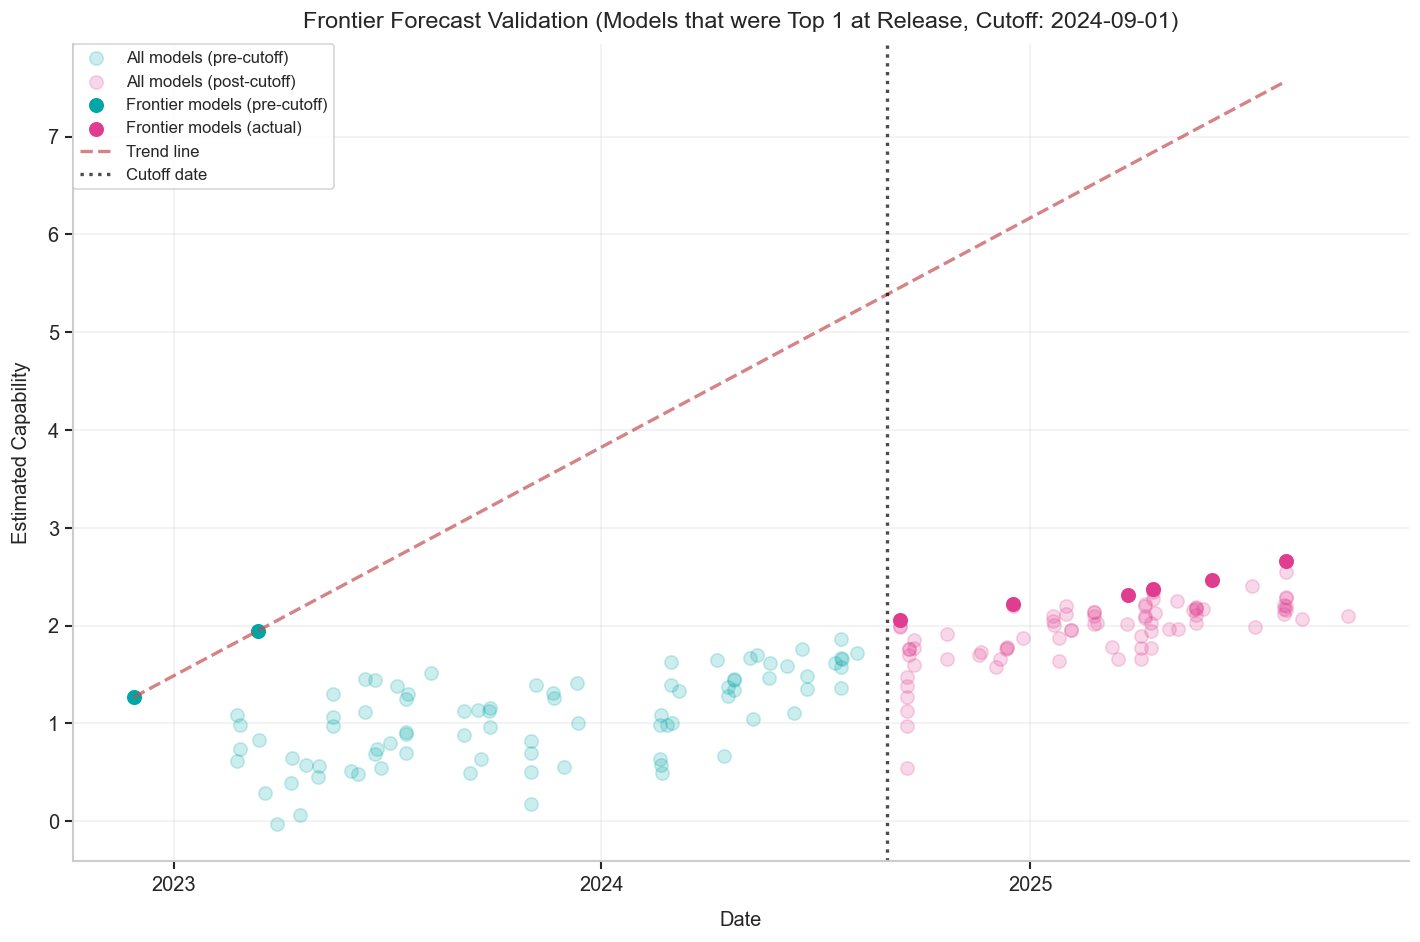

In [209]:
# Validate forecast accuracy using df_cm1 (full dataset)
validation_results = validate_forecast_accuracy(
    df_cm1, 
    CUTOFF_DATE, 
    TOP_N_MODELS, 
    label_frontier=LABEL_FRONTIER
)

if validation_results:
    print(f"\nValidation Results (cutoff: {CUTOFF_DATE}):")
    print(f"  MAE: {validation_results['mae']:.3f}")
    print(f"  RMSE: {validation_results['rmse']:.3f}")
    print(f"  R²: {validation_results['r2']:.3f}")
    print(f"  Annual growth rate: {validation_results['slope']:.3f}")
    print(f"  Training points: {validation_results['n_training']}")
    print(f"  Validation points: {validation_results['n_validation']}")


### 2. Create Future Forecast


Creating 3-year capability forecast using models that were top 1 at release...
Using 8 frontier model data points (from 170 total)
Frontier models: text-davinci-003, gpt-4-0314, o1-mini-2024-09-12_high, o1-2024-12-17_medium, gemini-2.5-pro-exp-03-25, o3-2025-04-16_high, gemini-2.5-pro-preview-06-05, gpt-5-2025-08-07_medium

Frontier Forecast (3 years, models that were top 1 at release):
  Annual growth rate: 0.376
  Model R²: 0.834

Forecast table:


,date,predicted_capability,ci_lower,ci_upper,pi_lower,pi_upper
0,2025-09-30,2.571540,2.328139,2.814942,2.328139,2.814942
1,2025-10-31,2.603459,2.349274,2.857645,2.349274,2.857645
2,2025-11-30,2.634349,2.369418,2.899280,2.369418,2.899280
3,2025-12-31,2.666268,2.389952,2.942584,2.389952,2.942584
4,2026-01-31,2.698187,2.410234,2.986141,2.410234,2.986141
5,2026-02-28,2.727018,2.428360,3.025675,2.428360,3.025675
6,2026-03-31,2.758937,2.448239,3.069634,2.448239,3.069634
7,2026-04-30,2.789826,2.467307,3.112345,2.467307,3.112345
8,2026-05-31,2.821745,2.486855,3.156636,2.486855,3.156636
9,2026-06-30,2.852635,2.505637,3.199633,2.505637,3.199633


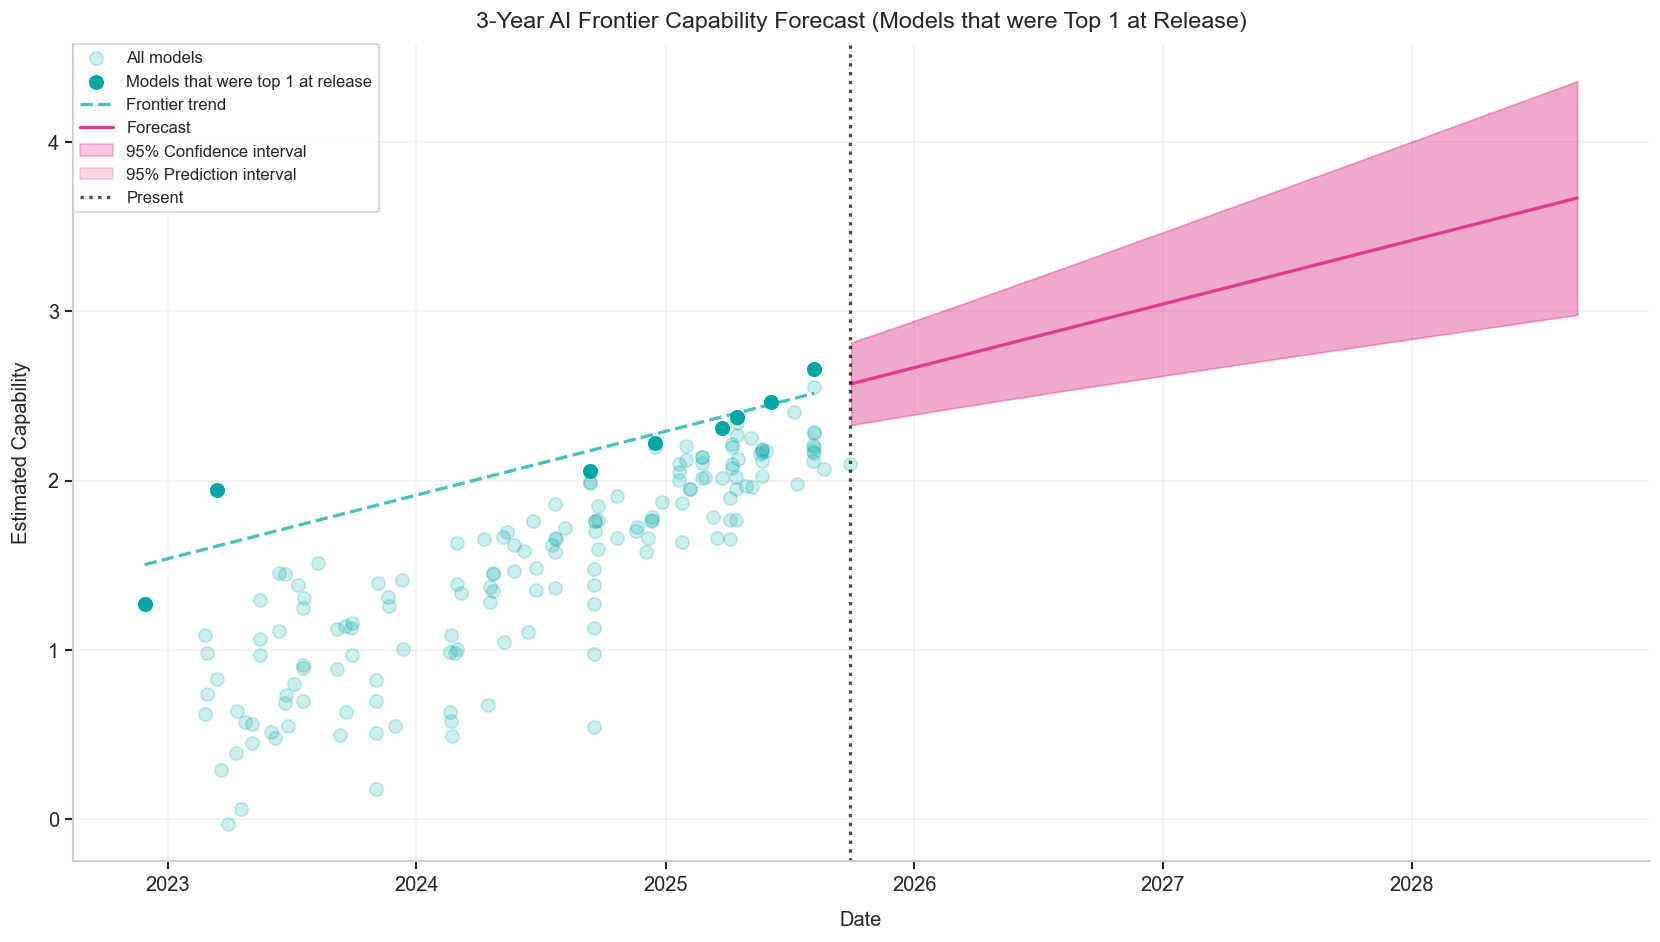

In [210]:
# Create future forecast using df_cm1 (full dataset)
forecast_results = create_future_forecast(
    df_cm1, 
    FORECAST_YEARS, 
    TOP_N_MODELS, 
    label_frontier=LABEL_FRONTIER
)

print(f"\nFrontier Forecast ({FORECAST_YEARS} years, models that were top {TOP_N_MODELS} at release):")
print(f"  Annual growth rate: {forecast_results['slope_per_year']:.3f}")
print(f"  Model R²: {forecast_results['r2']:.3f}")

# Display forecast table
print("\nForecast table:")
display(forecast_results['forecast_df'])


In [211]:
set(scores_df["benchmark"])

{'ANLI',
 'ARC AI2',
 'ARC-AGI',
 'Aider polyglot',
 'BBH',
 'Balrog',
 'BoolQ',
 'CadEval',
 'Cybench',
 'DeepResearch Bench',
 'Factorio learning environment',
 'Fiction.LiveBench',
 'FrontierMath-2025-02-28-Private',
 'FrontierMath-Tier-4-2025-07-01-Private',
 'GPQA diamond',
 'GSM8K',
 'GSO-Bench',
 'GeoBench',
 'HellaSwag',
 'LAMBADA',
 'Lech Mazur Writing',
 'LiveBench',
 'MATH level 5',
 'MMLU',
 'OSUniverse',
 'OSWorld',
 'OTIS Mock AIME 2024-2025',
 'OpenBookQA',
 'PIQA',
 'SWE-Bench verified',
 'ScienceQA',
 'SimpleBench',
 'Terminal Bench',
 'The Agent Company',
 'TriviaQA',
 'VPCT',
 'VideoMME',
 'WeirdML',
 'Winogrande'}

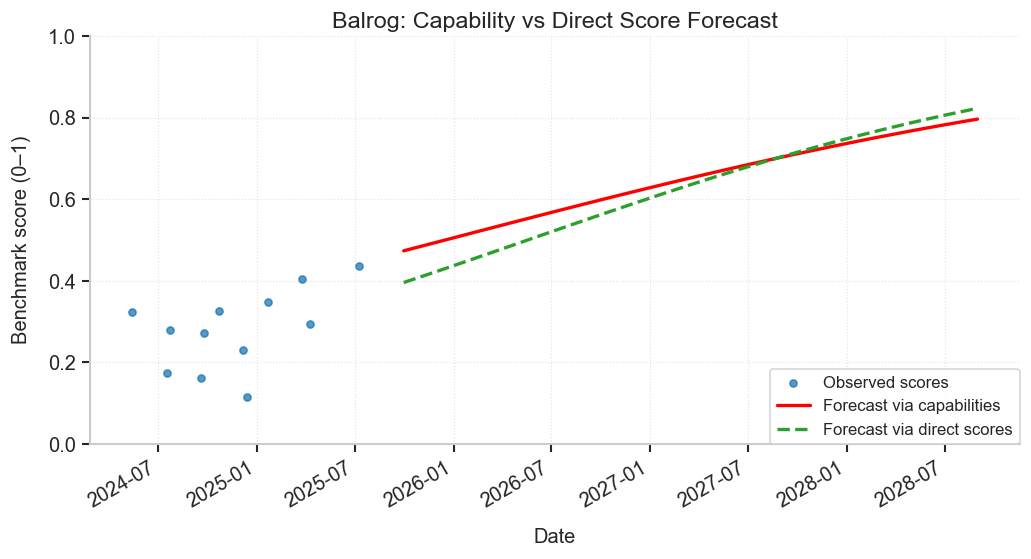

In [212]:
_ = compare_benchmark_forecasts(
    benchmark_name="Balrog",
    forecast_results=forecast_results,
    df_cm=df_cm1,
    df_db=df_db1,
    history_source_df=scores_df,  # from data_loader
    min_points=6,
)

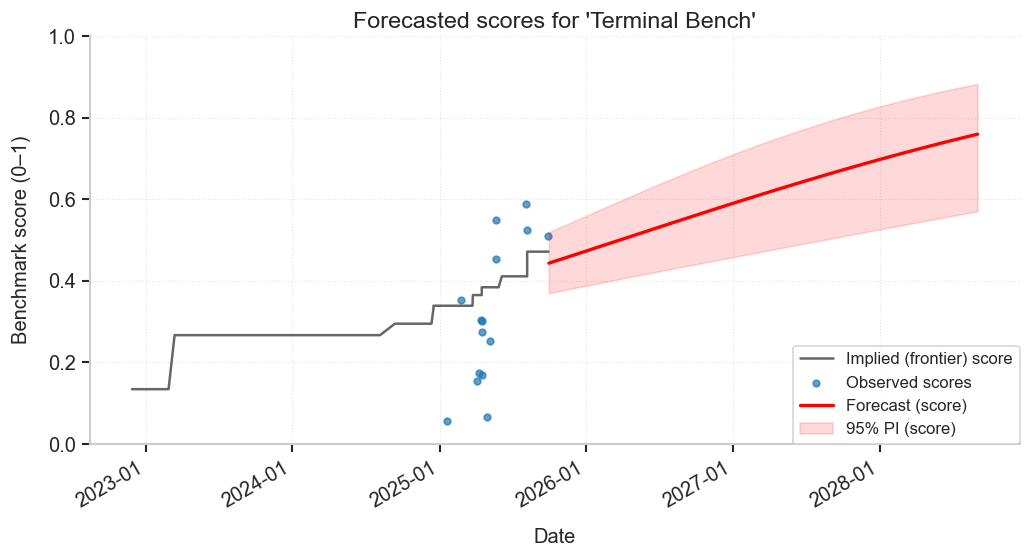

In [213]:
_ = plot_benchmark_forecast(
    benchmark_name="Terminal Bench",
    forecast_results=forecast_results,
    df_cm=df_cm1,
    df_db=df_db1,
    history_source_df=scores_df,  # or scores_df to overlay observed scores
    show_prediction_interval=True,
    show_confidence_interval=False,
)

### 3. Create Post-Cutoff Frontier Forecast


Creating post-cutoff (2024-09-01) 3-year forecast using models that were top 1 at release...

Post-cutoff Frontier Forecast (after 2024-09-01, top 1 at release, 3 years):
  Points used: 6
  Annual growth rate: 0.624
  Model R²: 0.956

Post-cutoff forecast table (first 12 months):


/Users/andrew/Epoch/benchmark-stitching/.venv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


,date,predicted_capability,ci_lower,ci_upper,pi_lower,pi_upper
0,2025-09-30,2.690244,2.574821,2.805667,2.574821,2.805667
1,2025-10-31,2.743183,2.613693,2.872673,2.613693,2.872673
2,2025-11-30,2.794414,2.650975,2.937853,2.650975,2.937853
3,2025-12-31,2.847353,2.689247,3.005459,2.689247,3.005459
4,2026-01-31,2.900292,2.727327,3.073257,2.727327,3.073257
5,2026-02-28,2.948108,2.761594,3.134622,2.761594,3.134622
6,2026-03-31,3.001047,2.799422,3.202671,2.799422,3.202671
7,2026-04-30,3.052278,2.835942,3.268613,2.835942,3.268613
8,2026-05-31,3.105217,2.873606,3.336827,2.873606,3.336827
9,2026-06-30,3.156448,2.909997,3.402899,2.909997,3.402899


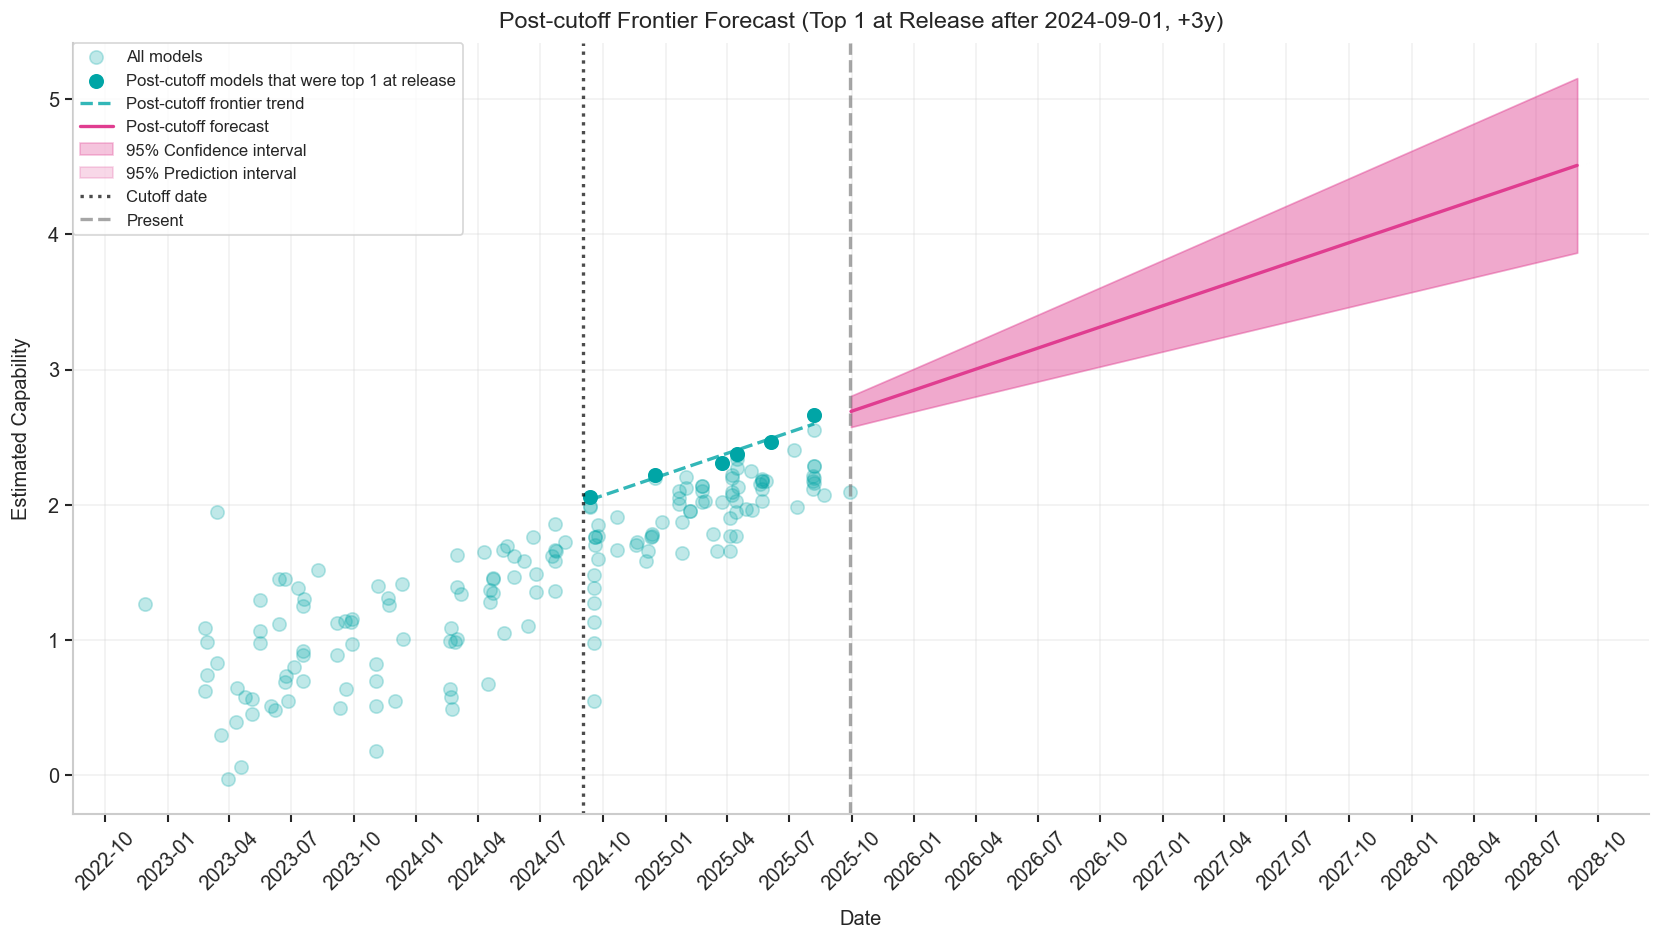

In [214]:
# Create post-cutoff frontier forecast using df_cm1 (full dataset)
post_cutoff_results = create_post_cutoff_frontier_forecast(
    df_cm1,
    cutoff_date=CUTOFF_DATE,
    forecast_years=FORECAST_YEARS,
    top_n_models=TOP_N_MODELS,
    label_frontier=LABEL_FRONTIER
)

if post_cutoff_results:
    print(f"\nPost-cutoff Frontier Forecast (after {CUTOFF_DATE}, top {TOP_N_MODELS} at release, {FORECAST_YEARS} years):")
    print(f"  Points used: {post_cutoff_results['n_points']}")
    print(f"  Annual growth rate: {post_cutoff_results['slope_per_year']:.3f}")
    print(f"  Model R²: {post_cutoff_results['r2']:.3f}")
    
    # Display forecast table
    print("\nPost-cutoff forecast table (first 12 months):")
    display(post_cutoff_results['forecast_df'].head(12))


### 4. Analyze Benchmark Saturation


Analyzing benchmark saturation forecasts...

Benchmark Saturation Forecasts:
  Total benchmarks analyzed: 39
  Benchmarks within 5 years: 39

Next benchmark to saturate:
  PIQA in 0.0 years

Top 10 benchmarks by saturation timeline:


,benchmark,difficulty,capability_needed,years_to_saturation,predicted_saturation_date
0,PIQA,-1.548408,-1.548408,0.0,2025-09-29
31,Balrog,2.650609,2.650609,0.0,2025-09-29
30,The Agent Company,2.558311,2.558311,0.0,2025-09-29
29,VPCT,2.469766,2.469766,0.0,2025-09-29
28,SimpleBench,2.357679,2.357679,0.0,2025-09-29
27,WeirdML,2.332737,2.332737,0.0,2025-09-29
26,SWE-Bench verified,2.325345,2.325345,0.0,2025-09-29
25,ARC-AGI,2.315992,2.315992,0.0,2025-09-29
24,OSWorld,2.246003,2.246003,0.0,2025-09-29
23,CadEval,2.093199,2.093199,0.0,2025-09-29


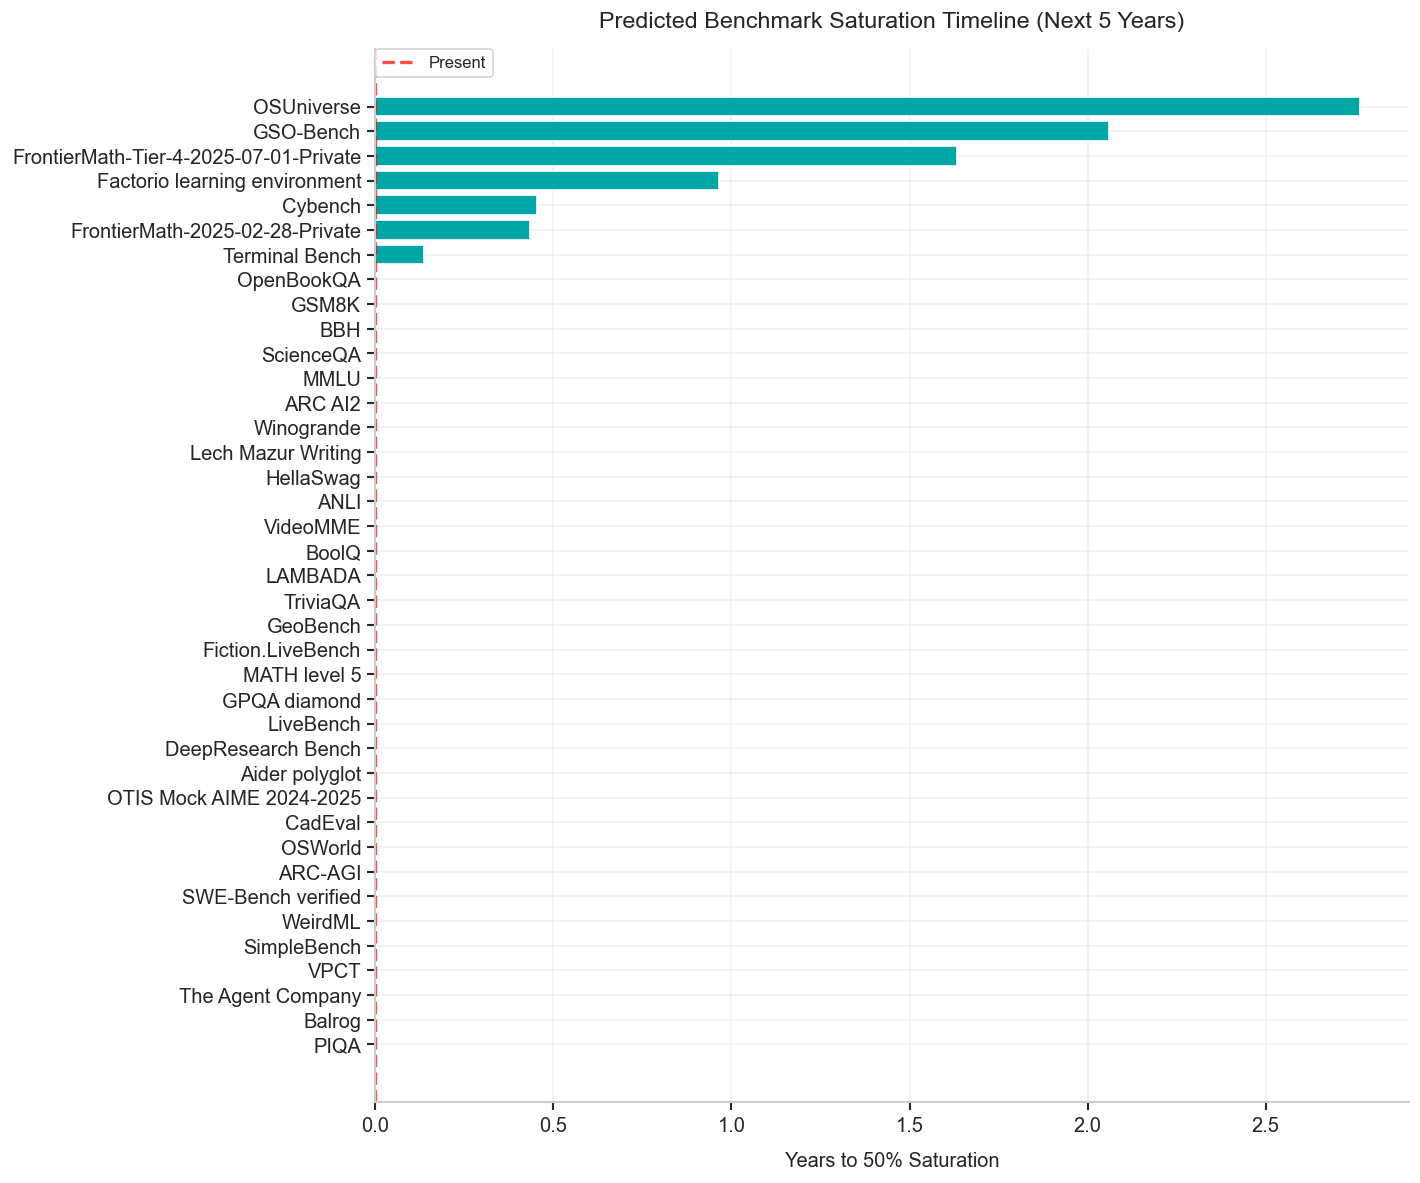

In [215]:
# Analyze benchmark saturation forecasts
saturation_forecasts = analyze_benchmark_saturation_forecasts(df_cm1, df_db1)

print("\nBenchmark Saturation Forecasts:")
print(f"  Total benchmarks analyzed: {len(saturation_forecasts)}")
print(f"  Benchmarks within 5 years: {len(saturation_forecasts[saturation_forecasts['years_to_saturation'] <= 5])}")

if len(saturation_forecasts) > 0:
    next_benchmark = saturation_forecasts.iloc[0]
    print(f"\nNext benchmark to saturate:")
    print(f"  {next_benchmark['benchmark']} in {next_benchmark['years_to_saturation']:.1f} years")
    
    print("\nTop 10 benchmarks by saturation timeline:")
    display(saturation_forecasts.head(10))


---
## Acceleration Detection

Apply the piecewise linear breakpoint detection approach to identify potential acceleration in AI capabilities.

### Piecewise Linear Breakpoint Detection

This approach (from `software_singularity.ipynb`) fits a piecewise linear model to capability data to detect acceleration points.


In [216]:
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

def piecewise_linear(x, slope1, intercept1, slope2, breakpoint):
    """Piecewise linear function with continuity at breakpoint"""
    intercept2 = slope1 * breakpoint + intercept1 - slope2 * breakpoint
    return np.where(x < breakpoint, slope1*x + intercept1, slope2*x + intercept2)

def fit_piecewise_linear(x, y, num_breaks=30):
    """Fit a piecewise linear model by scanning candidate breakpoints"""
    best = (-np.inf, None)
    xs, ys = x, y
    rng = xs.max() - xs.min()
    min_bp = xs.min() + 0.1 * rng
    max_bp = xs.max() - 0.1 * rng
    lower = [-np.inf, -np.inf, -np.inf, min_bp]
    upper = [ np.inf,  np.inf,  np.inf, max_bp]

    for bp in np.linspace(min_bp, max_bp, num_breaks):
        left = xs <= bp
        right = xs > bp
        if left.sum() < 2 or right.sum() < 2:
            continue

        # Initial guesses
        m1, b1 = np.polyfit(xs[left], ys[left], 1)
        m2, _  = np.polyfit(xs[right], ys[right], 1)
        i1 = np.mean(ys[left]) - m1 * np.mean(xs[left])
        p0 = [m1, i1, m2, bp]

        try:
            params, _ = curve_fit(
                piecewise_linear,
                xs, ys,
                p0=p0,
                bounds=(lower, upper),
                maxfev=2000
            )
            r2 = r2_score(ys, piecewise_linear(xs, *params))
            if r2 > best[0]:
                best = (r2, params)
        except Exception:
            pass

    return best[1], best[0]

def detect_acceleration_frontier(df_capabilities: pd.DataFrame, 
                                 num_breaks: int = 50,
                                 min_slope_ratio: float = 1.5):
    """
    Detect acceleration in frontier model capabilities using piecewise linear fitting.
    
    Args:
        df_capabilities: DataFrame with 'date' and 'estimated_capability' columns
        num_breaks: Number of candidate breakpoints to try
        min_slope_ratio: Minimum slope ratio to consider as acceleration
    
    Returns:
        Dictionary with detection results
    """
    df = prepare_model_data(df_capabilities)
    
    # Compute running maximum (frontier)
    df = df.sort_values('date_obj')
    df['running_max'] = df['estimated_capability'].cummax()
    
    # Get frontier models (those that set new records)
    frontier_df = df[df['estimated_capability'] == df['running_max']].copy()
    
    if len(frontier_df) < 10:
        print("Insufficient frontier data points for acceleration detection")
        return {}
    
    # Convert dates to years (numeric)
    x = mdates.date2num(frontier_df['date_obj'].values)
    y = frontier_df['estimated_capability'].values
    
    # Fit piecewise linear model
    params, r2 = fit_piecewise_linear(x, y, num_breaks=num_breaks)
    
    if params is None:
        print("Failed to fit piecewise linear model")
        return {}
    
    slope1, intercept1, slope2, bp = params
    
    # Convert breakpoint back to date (remove timezone to avoid comparison issues)
    breakpoint_date = mdates.num2date(bp).replace(tzinfo=None)
    
    # Calculate slope ratio
    slope_ratio = slope2 / slope1 if slope1 > 0 else np.inf
    
    # Check if acceleration detected
    acceleration_detected = slope_ratio >= min_slope_ratio
    
    # Visualize
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # All models (faded)
    ax.scatter(df['date_obj'], df['estimated_capability'],
              alpha=0.2, s=64, label='All models', color=colors[0], edgecolor='white', linewidths=0.5)
    
    # Frontier models
    ax.scatter(frontier_df['date_obj'], frontier_df['estimated_capability'],
              s=64, label='Frontier (running max)', color=colors[0], alpha=1, edgecolor='white', linewidths=0.5)
    
    # Piecewise fit
    x_fine = np.linspace(x.min(), x.max(), 400)
    y_fine = piecewise_linear(x_fine, *params)
    dates_fine = [mdates.num2date(d).replace(tzinfo=None) for d in x_fine]
    ax.plot(dates_fine, y_fine, '--', linewidth=2, label='Piecewise linear fit', color=colors[1])
    
    # Breakpoint line
    ax.axvline(x=breakpoint_date, color=colors[2], linestyle=':', linewidth=2, 
              label=f'Breakpoint: {breakpoint_date.strftime("%Y-%m-%d")}')
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Estimated Capability')
    ax.set_title(f'Frontier Acceleration Detection\n' +
                f'Pre-break slope: {slope1*365.25:.3f}/year, Post-break slope: {slope2*365.25:.3f}/year, ' +
                f'Ratio: {slope_ratio:.2f}x (R²={r2:.4f})')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    plt.xticks(rotation=0)
    plt.tight_layout()
    
    return {
        'breakpoint_date': breakpoint_date,
        'slope_pre': slope1,
        'slope_post': slope2,
        'slope_pre_per_year': slope1 * 365.25,
        'slope_post_per_year': slope2 * 365.25,
        'slope_ratio': slope_ratio,
        'r2': r2,
        'acceleration_detected': acceleration_detected,
        'frontier_df': frontier_df,
        'params': params
    }


### Run Acceleration Detection on Real Data


Running acceleration detection on frontier models...

Saved acceleration detection plot to outputs/notebooks/real_data_acceleration_detection.pdf


ACCELERATION DETECTION RESULTS
Breakpoint detected at: 2023-03-10
Pre-break slope: 1.974 capability units/year
Post-break slope: 0.270 capability units/year
Slope ratio: 0.14x
Model fit (R²): 0.9225
Acceleration detected: False

Comparison to known events:
  Days from ChatGPT release: 100 days
  Days from o1 release: -552 days

Frontier models around breakpoint (±6 months):


,model,date,estimated_capability
74,text-davinci-003,2022-11-28,1.268573
80,gpt-4-0314,2023-03-14,1.947561


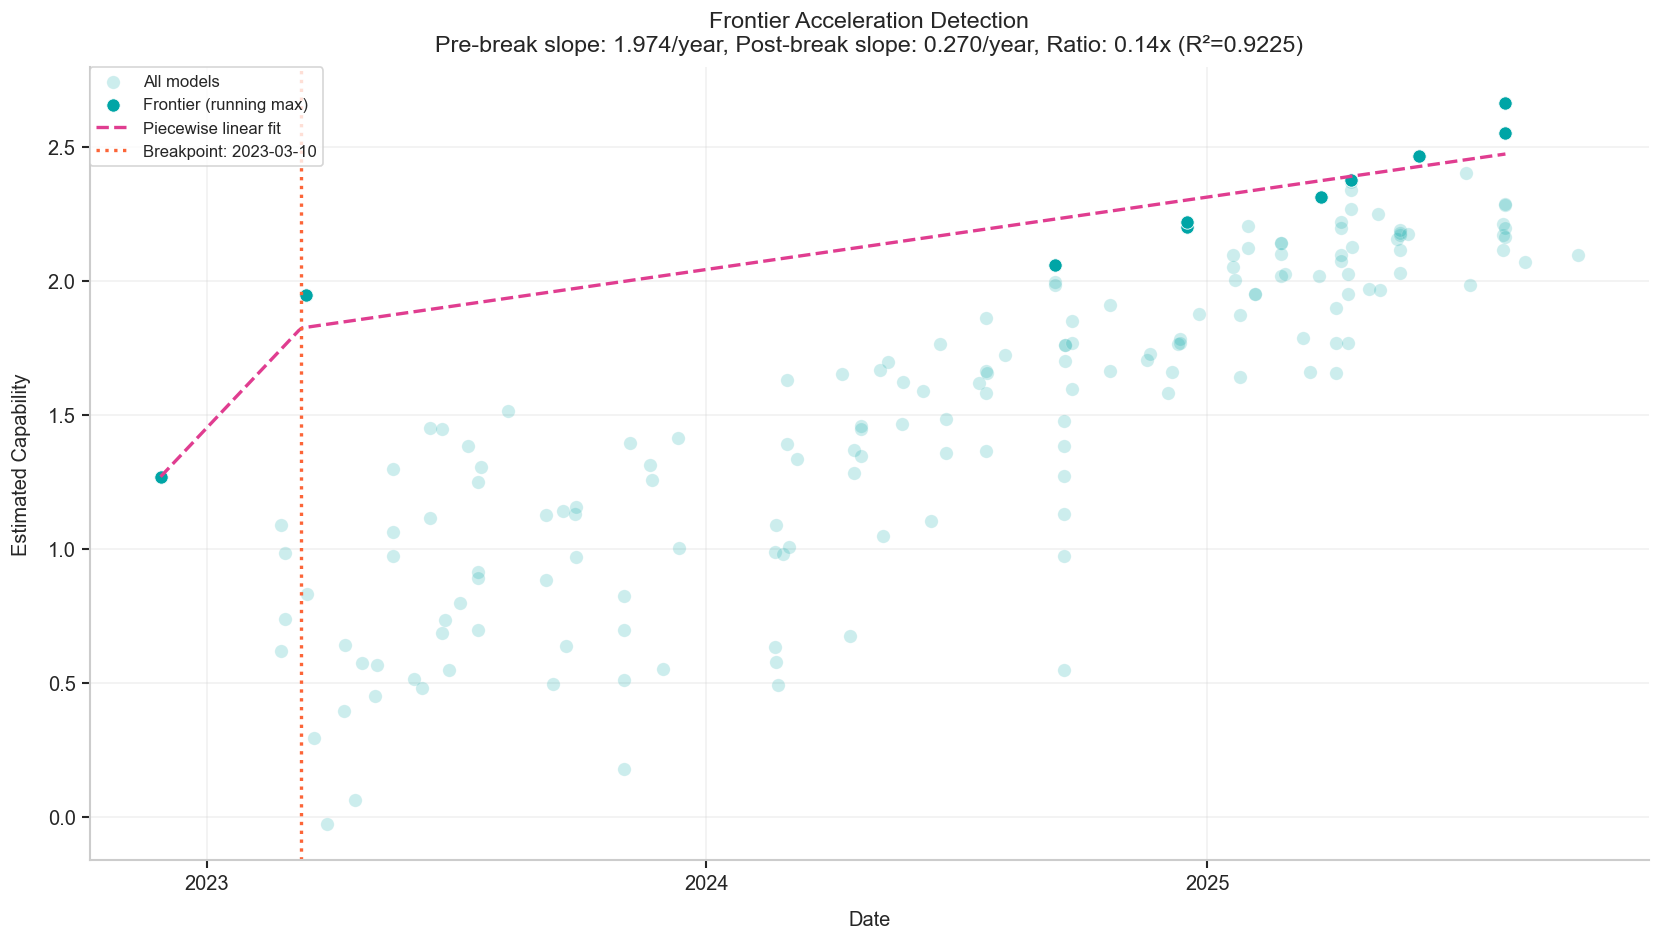

In [217]:
# Run acceleration detection on full dataset (df_cm1)
print("Running acceleration detection on frontier models...")
print("=" * 80)

accel_results = detect_acceleration_frontier(
    df_cm1,
    num_breaks=50,
    min_slope_ratio=1.5  # Detect if post-break is 1.5x faster than pre-break
)

# Save the acceleration detection plot
output_path = 'outputs/notebooks/real_data_acceleration_detection.pdf'
plt.savefig(output_path, bbox_inches='tight', dpi=300)
print(f"\nSaved acceleration detection plot to {output_path}\n")

if accel_results:
    print("\nACCELERATION DETECTION RESULTS")
    print("=" * 80)
    print(f"Breakpoint detected at: {accel_results['breakpoint_date'].strftime('%Y-%m-%d')}")
    print(f"Pre-break slope: {accel_results['slope_pre_per_year']:.3f} capability units/year")
    print(f"Post-break slope: {accel_results['slope_post_per_year']:.3f} capability units/year")
    print(f"Slope ratio: {accel_results['slope_ratio']:.2f}x")
    print(f"Model fit (R²): {accel_results['r2']:.4f}")
    print(f"Acceleration detected: {accel_results['acceleration_detected']}")
    
    # Compare to known events
    breakpoint = accel_results['breakpoint_date']
    chatgpt_date = pd.Timestamp('2022-11-30')
    o1_date = pd.Timestamp('2024-09-12')
    
    print(f"\nComparison to known events:")
    print(f"  Days from ChatGPT release: {(breakpoint - chatgpt_date).days} days")
    print(f"  Days from o1 release: {(breakpoint - o1_date).days} days")
    
    # Show frontier models around the breakpoint
    frontier_df = accel_results['frontier_df']
    bp_date = accel_results['breakpoint_date']
    window = pd.Timedelta(days=180)  # 6 months
    
    around_bp = frontier_df[
        (frontier_df['date_obj'] >= bp_date - window) &
        (frontier_df['date_obj'] <= bp_date + window)
    ][['model', 'date', 'estimated_capability']].sort_values('date')
    
    if len(around_bp) > 0:
        print(f"\nFrontier models around breakpoint (±6 months):")
        display(around_bp)


### Compare Detection on Different Datasets

Let's also test the acceleration detection on the pre-cutoff dataset (df_cm2) to see if it detects earlier patterns.


In [218]:
# Run on pre-cutoff dataset
print("\nRunning acceleration detection on pre-cutoff dataset (df_cm2)...")
print("=" * 80)

accel_results_pre = detect_acceleration_frontier(
    df_cm2,
    num_breaks=30,  # Fewer breaks since less data
    min_slope_ratio=1.5
)

if accel_results_pre:
    print("\nPRE-CUTOFF ACCELERATION DETECTION RESULTS")
    print("=" * 80)
    print(f"Breakpoint detected at: {accel_results_pre['breakpoint_date'].strftime('%Y-%m-%d')}")
    print(f"Pre-break slope: {accel_results_pre['slope_pre_per_year']:.3f} capability units/year")
    print(f"Post-break slope: {accel_results_pre['slope_post_per_year']:.3f} capability units/year")
    print(f"Slope ratio: {accel_results_pre['slope_ratio']:.2f}x")
    print(f"Model fit (R²): {accel_results_pre['r2']:.4f}")
    print(f"Acceleration detected: {accel_results_pre['acceleration_detected']}")



Running acceleration detection on pre-cutoff dataset (df_cm2)...
Insufficient frontier data points for acceleration detection


# How big is the difference between fits, depending on time range?

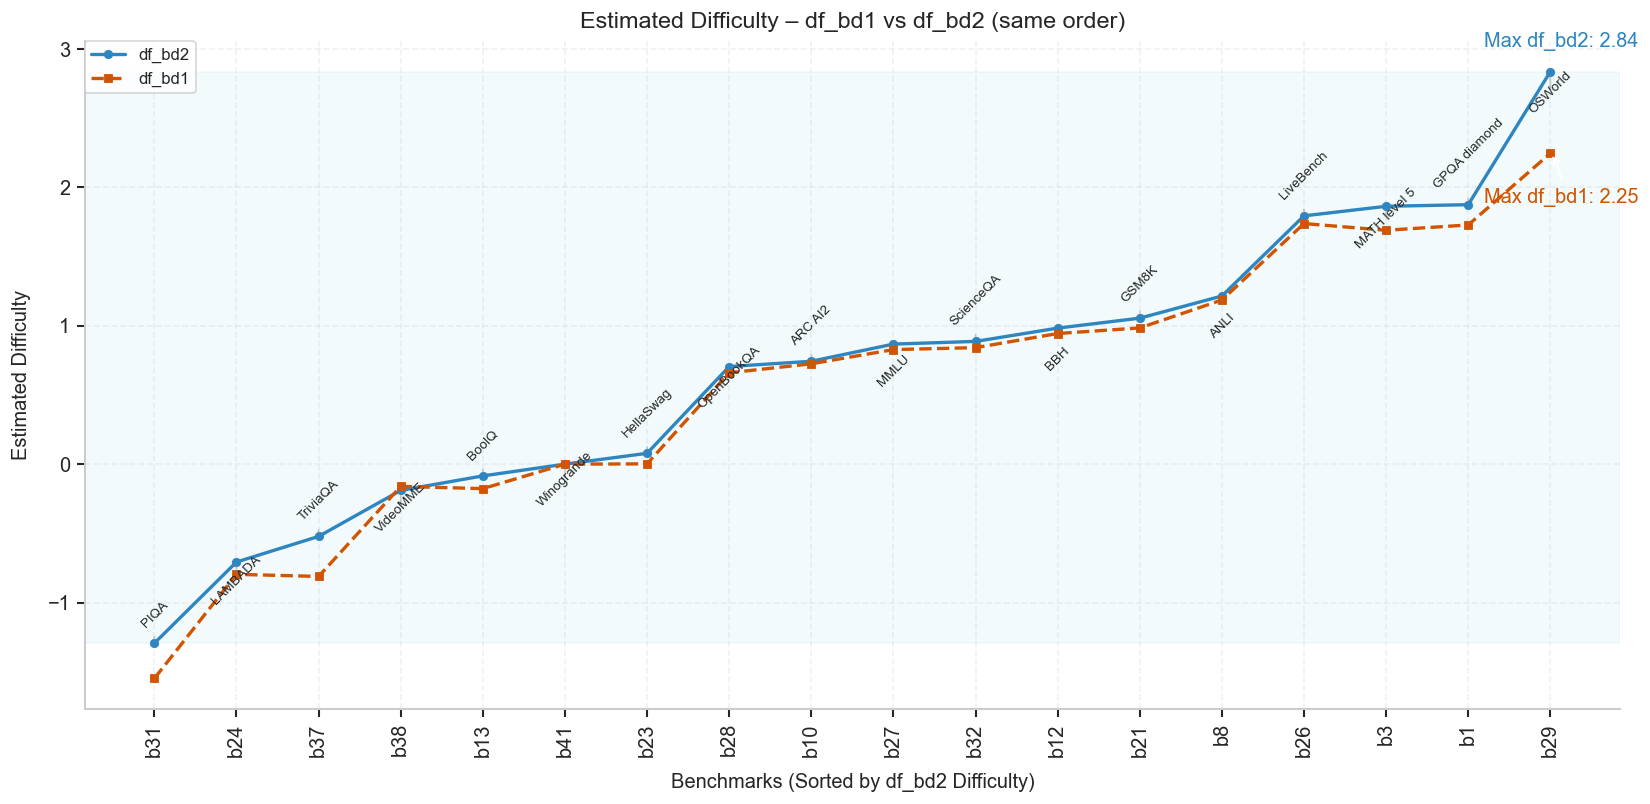

In [219]:
# --- 1. Sort df_db2 exactly as before ----------------------------------------
sorted_df2 = df_db2.sort_values(by="estimated_difficulty").reset_index(drop=True)

# --- 2. Align df_bd1 to that order -------------------------------------------
#   (will silently insert NaN if df_bd1 is missing a benchmark_id)
aligned_df1 = (
    df_db1                      # original
    .set_index("benchmark_id")  # use benchmark_id as index
    .reindex(sorted_df2["benchmark_id"])  # re-order / align
    .reset_index()              # restore column shape
)

# --- 3. Grab the columns you need -------------------------------------------
x              = np.arange(len(sorted_df2))                 # shared x-axis
y2_difficulty  = sorted_df2["estimated_difficulty"].values   # df_bd2 (sorted)
y1_difficulty  = aligned_df1["estimated_difficulty"].values  # df_bd1 (aligned)
bench_ids      = sorted_df2["benchmark_id"].values
bench_names    = sorted_df2["benchmark_name"].values

# --- 4. Plot -----------------------------------------------------------------
plt.figure(figsize=(14, 8))

# df_bd2 (your original line)
plt.plot(
    x, y2_difficulty,
    marker='o', linestyle='-', linewidth=2, markersize=5,
    color='#2E86C1', label='df_bd2'
)

# df_bd1 (second line – tweak style/colour as you like)
plt.plot(
    x, y1_difficulty,
    marker='s', linestyle='--', linewidth=2, markersize=5,
    color='#D35400', label='df_bd1'
)

# --- 5. Cosmetics (labels, grid, ticks, annotations) -------------------------
plt.xlabel('Benchmarks (Sorted by df_bd2 Difficulty)')
plt.ylabel('Estimated Difficulty')
plt.title('Estimated Difficulty – df_bd1 vs df_bd2 (same order)')
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(x, bench_ids, rotation=90)

# (Optional) annotate benchmark names just once to avoid clutter
for i, (diff, name) in enumerate(zip(y2_difficulty, bench_names)):
    y_offset = 10 if i % 2 == 0 else -25
    plt.annotate(
        name,
        xy=(i, diff),
        xytext=(0, y_offset),
        textcoords='offset points',
        ha='center', fontsize=8, rotation=45,
        arrowprops=dict(arrowstyle='-', color='gray', alpha=0.4)
    )

# Add legend to distinguish the two data sources
plt.legend()

# Light background band (optional)
plt.axhspan(y2_difficulty.min(), y2_difficulty.max(), alpha=0.1, color='skyblue')

# Min/Max annotations for each line (optional but illustrative)
plt.annotate(f'Max df_bd2: {y2_difficulty.max():.2f}',
             xy=(x[y2_difficulty.argmax()], y2_difficulty.max()),
             xytext=(-40, 15), textcoords='offset points',
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'),
             color='#2E86C1')

plt.annotate(f'Max df_bd1: {np.nanmax(y1_difficulty):.2f}',
             xy=(x[np.nanargmax(y1_difficulty)], np.nanmax(y1_difficulty)),
             xytext=(-40, -30), textcoords='offset points',
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'),
             color='#D35400')

# Make room for rotated x-labels
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.savefig("outputs/notebooks/benchmark_difficulty_comparison_bd1_vs_bd2_sorted_by_bd2.pdf", dpi=300, bbox_inches='tight')
plt.show()


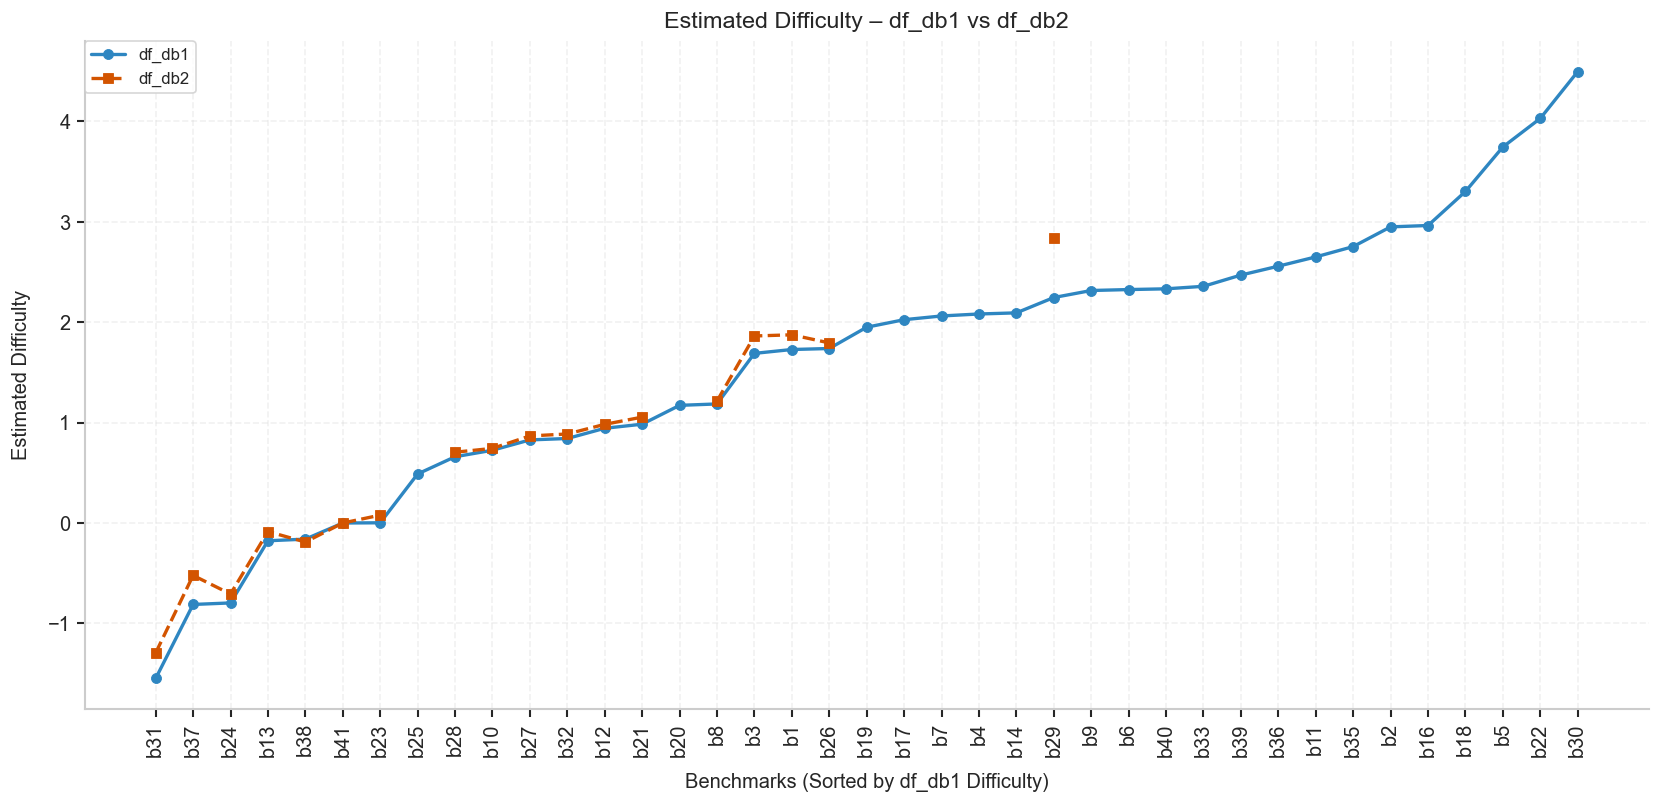

In [220]:
# ──────────────────────────────────────────────────────────────
# 1. Sort df_db1 by difficulty (defines x-axis order)
# ──────────────────────────────────────────────────────────────
sorted_df1 = (
    df_db1
    .sort_values(by="estimated_difficulty")
    .reset_index(drop=True)
)

# ──────────────────────────────────────────────────────────────
# 2. (Optional) deduplicate df_db2 on benchmark_id
#     – keeps the HIGHEST difficulty row per benchmark_id
#       (swap for mean/median if you prefer)
# ──────────────────────────────────────────────────────────────
df_db2_dedup = (
    df_db2
    .sort_values("estimated_difficulty", ascending=False)  # largest first
    .drop_duplicates(subset="benchmark_id", keep="first")
)

# ──────────────────────────────────────────────────────────────
# 3. Align df_db2 to df_db1 order
#    Any benchmark missing in df_db2 becomes NaN
# ──────────────────────────────────────────────────────────────
aligned_df2 = (
    df_db2_dedup
    .set_index("benchmark_id")
    .reindex(sorted_df1["benchmark_id"])   # align to df_db1
    .reset_index()
)

# ──────────────────────────────────────────────────────────────
# 4. Prepare data for plotting
# ──────────────────────────────────────────────────────────────
x  = np.arange(len(sorted_df1))                       # shared x-coords
y1 = sorted_df1["estimated_difficulty"].values        # df_db1 values
y2 = aligned_df2["estimated_difficulty"].values       # df_db2 values (aligned)

bench_ids   = sorted_df1["benchmark_id"].values
bench_names = sorted_df1["benchmark_name"].values     # if you want labels

# ──────────────────────────────────────────────────────────────
# 5. Plot
# ──────────────────────────────────────────────────────────────
plt.figure(figsize=(14, 8))

plt.plot(x, y1, marker='o', linestyle='-', linewidth=2, markersize=6,
         color='#2E86C1', label='df_db1')
plt.plot(x, y2, marker='s', linestyle='--', linewidth=2, markersize=6,
         color='#D35400', label='df_db2')

plt.xlabel('Benchmarks (Sorted by df_db1 Difficulty)')
plt.ylabel('Estimated Difficulty')
plt.title('Estimated Difficulty – df_db1 vs df_db2')
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(x, bench_ids, rotation=90)
plt.legend()

# # Optional annotation block (commented-out to keep the plot clean)
# for i, (diff, name) in enumerate(zip(y1, bench_names)):
#     y_offset = 10 if i % 2 == 0 else -25
#     plt.annotate(
#         name,
#         xy=(i, diff),
#         xytext=(0, y_offset),
#         textcoords='offset points',
#         ha='center', fontsize=8, rotation=45,
#         arrowprops=dict(arrowstyle='-', color='gray', alpha=0.4)
#     )

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # room for rotated labels
plt.savefig("outputs/notebooks/benchmark_difficulty_comparison_bd1_vs_bd2_sorted_by_bd1.pdf", dpi=300, bbox_inches='tight')
plt.show()


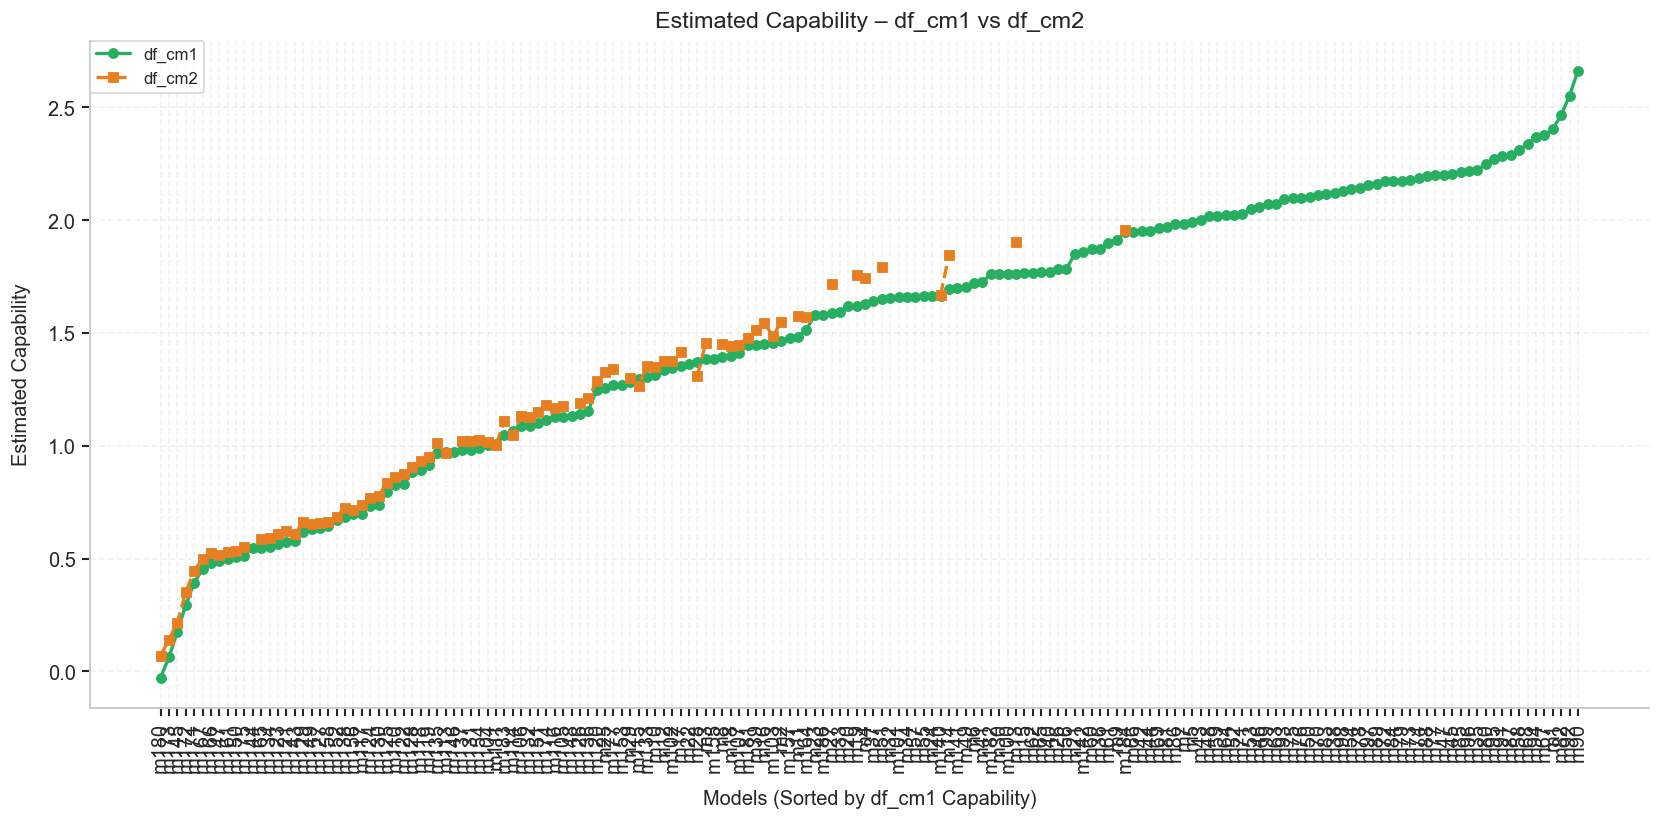

In [221]:
# ──────────────────────────────────────────────────────────────
# 1. Sort df_cm1 by capability (this defines the x-axis order)
# ──────────────────────────────────────────────────────────────
sorted_df1 = (
    df_cm1
    .sort_values(by="estimated_capability")
    .reset_index(drop=True)
)

# ──────────────────────────────────────────────────────────────
# 2. Remove duplicate model_id rows in df_cm2
#    (keep the row with the highest capability for each model_id)
#    ──> swap this block out if you prefer a mean/median instead
# ──────────────────────────────────────────────────────────────
df_cm2_dedup = (
    df_cm2
    .sort_values("estimated_capability", ascending=False)  # biggest first
    .drop_duplicates(subset="model_id", keep="first")      # keep that row
)

# Optional sanity check – uncomment to see what was removed:
# dupes = df_cm2[df_cm2.duplicated('model_id', keep=False)]
# print(f"Found {len(dupes)} duplicate rows in df_cm2"); dupes.head()

# ──────────────────────────────────────────────────────────────
# 3. Align df_cm2 (deduped) to the df_cm1 order
#    Any model_id missing from df_cm2 becomes NaN (gap in the line)
# ──────────────────────────────────────────────────────────────
aligned_df2 = (
    df_cm2_dedup
    .set_index("model_id")
    .reindex(sorted_df1["model_id"])   # align to df_cm1 order
    .reset_index()
)

# ──────────────────────────────────────────────────────────────
# 4. Prepare data for plotting
# ──────────────────────────────────────────────────────────────
x  = np.arange(len(sorted_df1))                      # shared x-coords
y1 = sorted_df1["estimated_capability"].values       # df_cm1 values
y2 = aligned_df2["estimated_capability"].values      # df_cm2 values (aligned)

model_ids   = sorted_df1["model_id"].values
model_names = sorted_df1["model"].values

# ──────────────────────────────────────────────────────────────
# 5. Plot
# ──────────────────────────────────────────────────────────────
plt.figure(figsize=(14, 8))

plt.plot(x, y1, marker='o', linestyle='-', linewidth=2, markersize=6,
         color='#27AE60', label='df_cm1')
plt.plot(x, y2, marker='s', linestyle='--', linewidth=2, markersize=6,
         color='#E67E22', label='df_cm2')

plt.xlabel('Models (Sorted by df_cm1 Capability)')
plt.ylabel('Estimated Capability')
plt.title('Estimated Capability – df_cm1 vs df_cm2')
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(x, model_ids, rotation=90)
plt.legend()

# #   Annotate each point once (using df_cm1) to avoid clutter
# for i, (cap, name) in enumerate(zip(y1, model_names)):
#     y_offset = 10 if i % 2 == 0 else -25
#     plt.annotate(
#         name,
#         xy=(i, cap),
#         xytext=(0, y_offset),
#         textcoords='offset points',
#         ha='center', fontsize=8, rotation=45,
#         arrowprops=dict(arrowstyle='-', color='gray', alpha=0.4)
#     )

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # room for rotated x-labels
plt.savefig("outputs/notebooks/model_capability_comparison_cm1_vs_cm2.pdf", dpi=300, bbox_inches='tight')
plt.show()
